# Music-Learning

## Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in [`1`](https://arxiv.org/abs/1612.01840).

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, auc, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.preprocessing import LabelEncoder

# Classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import librosa
from IPython.display import Audio
import scipy
from tinytag import TinyTag
from genres import post_processing

import ast
import os
import cmath
import csv

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# utility imports from .py files
from plot_utils import basic_plot, bar_plot
from dataset_utils import drop_complex_cols, get_top_genres, load
from utils import write_cm_on_file

We present two versions of the notebook, associated with the two binary value of  '__VERSION__':
- 0: use the dataset from FMA repository
- 1: use our dataset, extracted by the mp3 archive of the FMA repository

In [2]:
VERSION = 1

## Data preprocessing
There is the need to do some preliminar operations on the data extracted by the .mp3 files:

1. First, there are some columns (the 'Fourier' related) that have complex numbers as values.
These values can't be treated by the ML models so are discared

2. The labels have to be encoded to be processed in the right way

In [6]:
# Open file, extract feature set and label set
if VERSION:
    path = "out.csv"
    dataframe = pd.read_csv(path)
    y = dataframe["genre"]
    dataframe = dataframe.drop(columns=["title", "artist", "filename", "album", "genre"])
    dataframe = dataframe.drop(columns=drop_complex_cols(dataframe))
    X = dataframe.drop(columns=["fourier_tempogram_std"])

    # Label encoding and extraction of uniques for later purposes
    le = LabelEncoder()
    y = le.fit_transform(y)
    labels = pd.Series(y).unique()
    
else:
    path = "dataset/fma_metadata/"
    tracks_file = "tracks.csv"
    features_file = "features.csv"
    ds_features = load(path+features_file)
    ds_tracks = load(path+tracks_file)
    medium = ds_tracks['set', 'subset'] <= 'medium'
    X = ds_features.loc[medium, 'mfcc']
    y = ds_tracks.loc[medium, ('track', 'genre_top')]
    labels = y.unique()


# Split into train/validate/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                            test_size=0.10)

### Oversampling
We propose both SMOTE and RandomOversampler methods

In [ ]:
# summarize distribution 
counter = Counter(y_train) 
classes = {} 
for k,v in counter.items(): 
    per = v / len(y_train) * 100 
    classes[k] = v 
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per)) 
     

max_class = max(classes, key=classes.get) 
print(max_class) 
for k,v in classes.items(): 
    if v < classes[max_class]/20: 
        classes[k] = v * 10 
    elif v < classes[max_class]/10: 
        classes[k] = v * 5 
    elif v < classes[max_class]/5: 
        classes[k] = math.ceil(v * 2.5) 
    elif v < classes[max_class]/2.5: 
        classes[k] = math.ceil(v * 1.5) 
    elif v < classes[max_class]/2: 
        classes[k] = math.ceil(v * 1.25) 
     

# transform the dataset 
oversample = SMOTE(sampling_strategy=classes) 
X_train, y_train = oversample.fit_resample(X_train, y_train) 
 
# define oversampling strategy 
#oversample = RandomOverSampler(sampling_strategy=strategy) 
# fit and apply the transform 
#X_train, y_train = oversample.fit_resample(X_train, y_train) 
 
# summarize distribution 
counter = Counter(y_train) 
for k,v in counter.items(): 
    per = v / len(y_train) * 100 
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

## SVM
The first classifier that we evaluate is Support Vector Machine.<br>
Based on the online literature, the suited kernel function seems to be 'rfb', so it was our choice to use it too.
We recall that the radial basis function (rbf) $K(\textbf{x}, \textbf{x'})$ has the following form:<br>
<center>$K(\textbf{x}, \textbf{x'}) = e^{-\frac{||\textbf{x} - \textbf{x'}||^2}{2\sigma^2}}$</center>
<br>
The SVC implementation offered by scikit uses, among the parameters, a $C$ that is used for regularization, with a squared l2 penality function 

### Parameter tuning
Tuning was made to find the suited value for $C$

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: Us

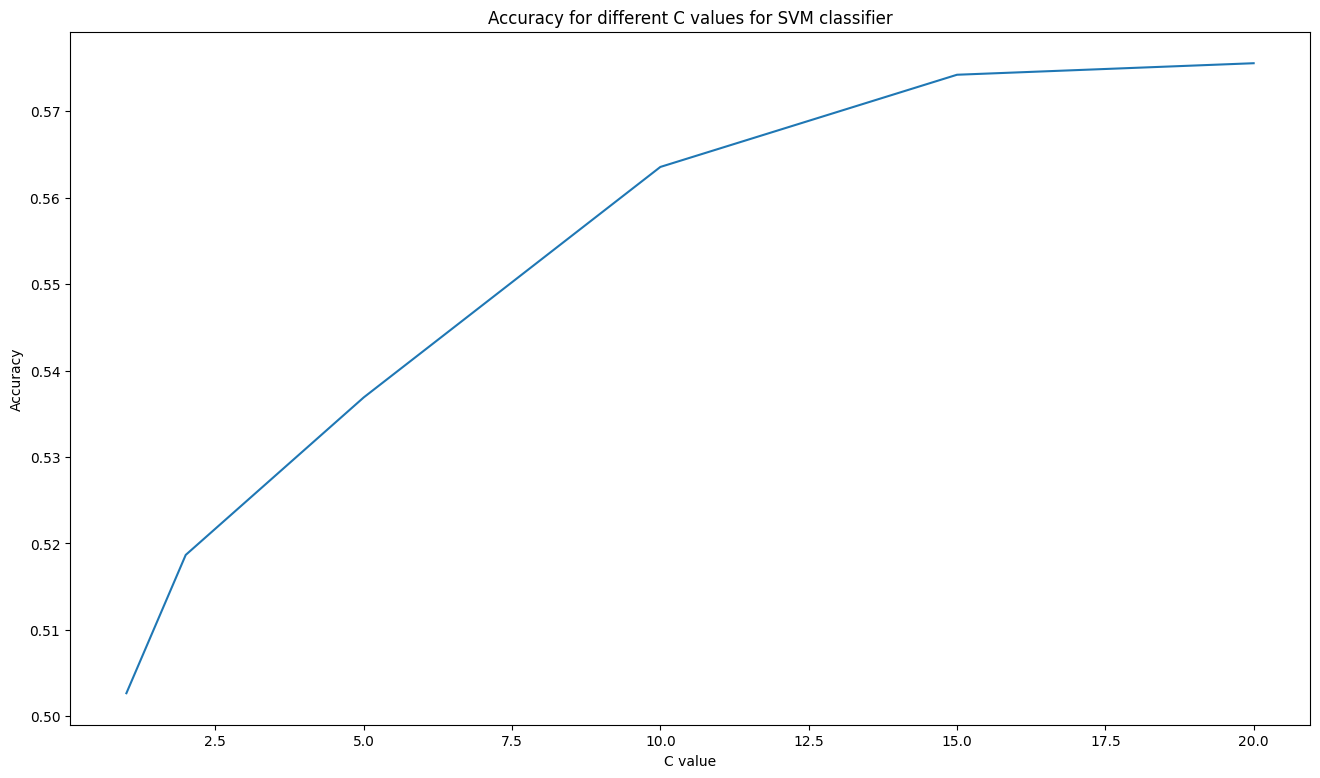

In [65]:
C_values = [1, 2, 5, 10, 15, 20]
svm_scores = []

for C in C_values:
    svm_clf = skl.svm.SVC(C=C, kernel='rbf').fit(X_train, y_train)
    svm_scores.append(np.asarray(cross_val_score(svm_clf, X_validate, y_validate, cv=2)).mean())
    
basic_plot((16,9), C_values, svm_scores, "C value", "Accuracy", 
           "Accuracy for different C values for SVM classifier")

In [28]:
# Given which is the best value of C, we train evaluate and test the model
# saving the results.
C_best = 20
svm_clf = skl.svm.SVC(C=C_best, kernel='rbf').fit(X_train, y_train)
print(cross_val_score(svm_clf, X_validate, y_validate, cv=2))  # print validation score

svm_predictions = svm_clf.predict(X_test)
print(svm_clf.score(X_test,y_test))                           # print accuracy

# Gather metrics
if VERSION:
    svm_precision = precision_score(y_test, svm_predictions, average=None, labels=labels)
    svm_recall = recall_score(y_test, svm_predictions, average=None, labels=labels)
    svm_f1 = f1_score(y_test, svm_predictions, average=None, labels=labels)
    svm_cm = confusion_matrix(y_test, svm_predictions, labels=labels)
    
else:
    svm_precision_fma = precision_score(y_test, svm_predictions, average=None, labels=labels)
    svm_recall_fma = recall_score(y_test, svm_predictions, average=None, labels=labels)
    svm_f1_fma = f1_score(y_test, svm_predictions, average=None, labels=labels)
    svm_cm_fma = confusion_matrix(y_test, svm_predictions, labels=labels)

print("------------------------- SVM completed -------------------------")

[0.49287749 0.4957265 ]
0.5307692307692308
------------------------- SVM completed -------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
## Output the confusion matrix on a .csv file
string_labels = le.inverse_transform(labels)
write_cm_on_file(cm=svm_cm, labels=string_labels, path="confusion_matrix_svm.csv")

## LR
The second classifier used is Logistic Regression.
This classifier can use different solvers with different associated penalities

### Model tuning
Here, we evaluated different solvers with their penality

/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is

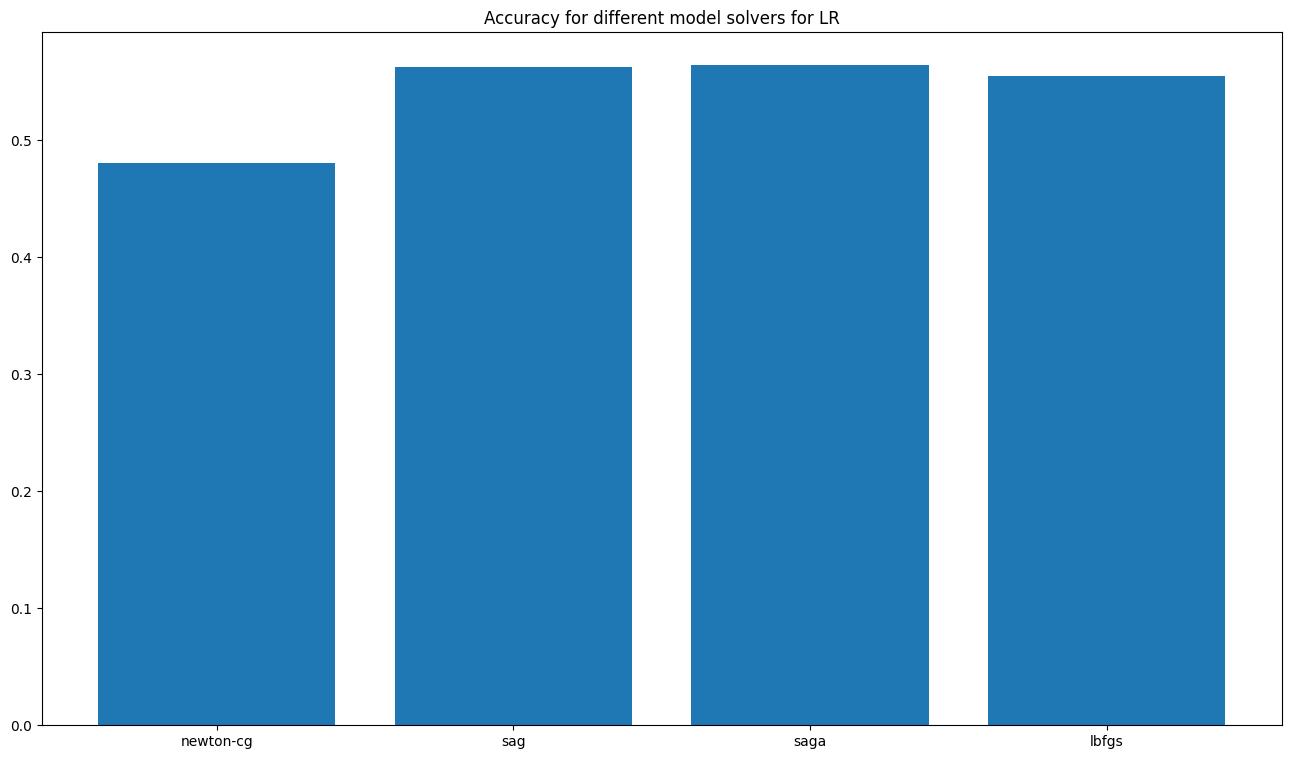

In [67]:
model_solv = {'newton-cg':'l2', 'sag':'l2', 'saga':'l1', 'lbfgs':'l2'}
lr_scores = []
for solver in model_solv:
    lr_clf = LogisticRegression(C=1, penalty=model_solv[solver], dual=False, solver=solver).fit(
        X_train, y_train)
    lr_scores.append(np.asarray(cross_val_score(lr_clf, X_validate, y_validate, cv=2)).mean())
bar_plot((16,9), lr_scores, list(model_solv.keys()), 
         "Accuracy for different model solvers for LR")

In [68]:
solver = "saga"
penalty = 'l1' 
lr_clf = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga').fit(X_train, y_train)
    #lr_clf.fit(X_train, y_train)
print(np.asarray(cross_val_score(lr_clf, X_validate, y_validate, cv=2)).mean())
lr_predictions = lr_clf.predict(X_test) 
print(lr_clf.score(X_test, y_test))

if VERSION:
    lr_precision = precision_score(y_test, lr_predictions, average=None, labels=labels)
    lr_recall = recall_score(y_test, lr_predictions, average=None, labels=labels)
    lr_f1 = f1_score(y_test, lr_predictions, average=None, labels=labels)
    lr_cm = confusion_matrix(y_test, lr_predictions, labels=labels)
else:
    lr_precision_fma = precision_score(y_test, lr_predictions, average=None, labels=labels)
    lr_recall_fma = recall_score(y_test, lr_predictions, average=None, labels=labels)
    lr_f1_fma = f1_score(y_test, lr_predictions, average=None, labels=labels)
    lr_cm_fma = confusion_matrix(y_test, lr_predictions, labels=labels)

print("------------------------- LR completed -------------------------")

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.5640000000000001
0.612
------------------------- LR completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## kNN
As third classifier we have k-Nearest-Neighbours.
This classifier works by considering the $k$ nearest points to a given $\textbf{x}$

## Model tuning
Tuning was made on the value for parameter $k$

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: Us

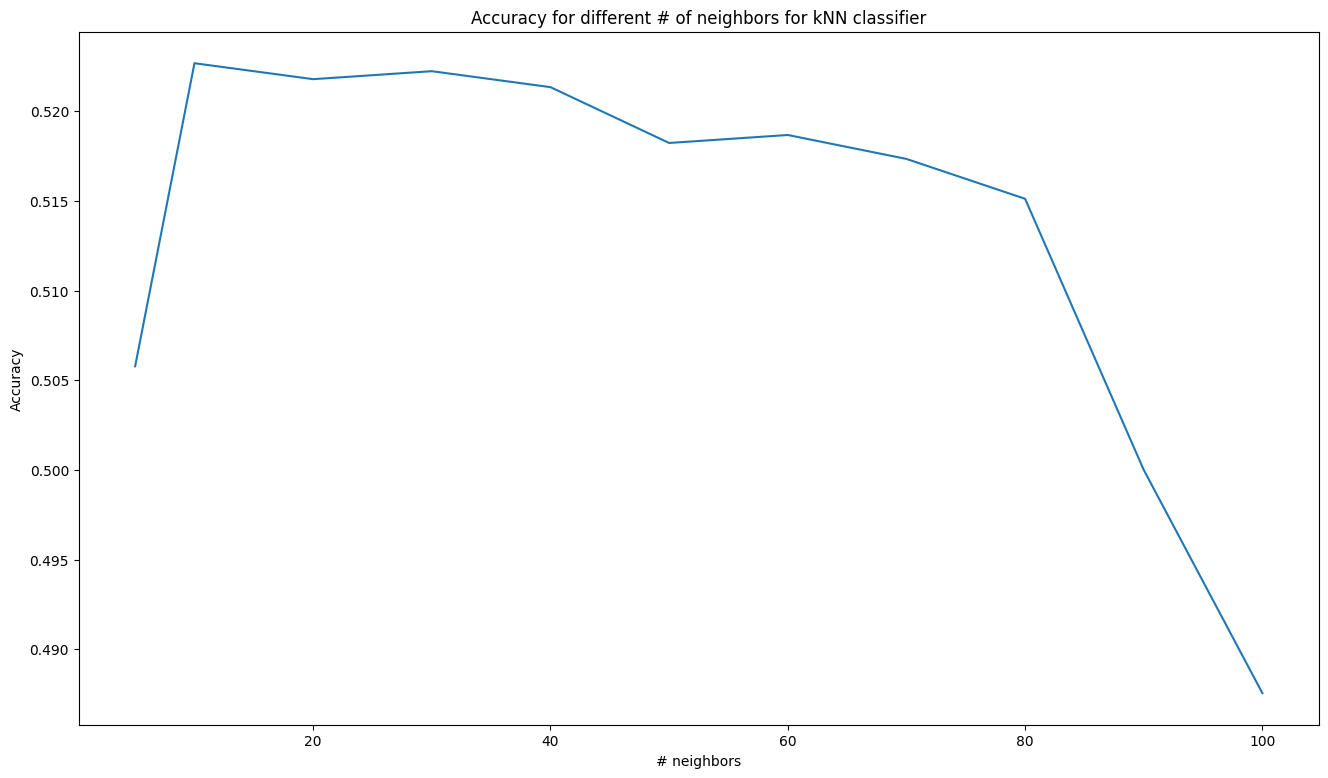

In [69]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
#X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                            #test_size=0.10)
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
knn_scores = []
for k in k_values:
    knn_clf = KNeighborsClassifier(k)
    knn_clf.fit(X_train, y_train)
    knn_scores.append(np.asarray(cross_val_score(knn_clf, X_validate, y_validate, cv=2)).mean())
    
basic_plot((16,9), k_values, knn_scores, "# neighbors", "Accuracy", 
           "Accuracy for different # of neighbors for kNN classifier")

In [23]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV

knn = KNeighborsClassifier(n_neighbors=10)#.fit(X, y)
#sfs = SequentialFeatureSelector(knn, n_features_to_select=10)
X_new = RFECV(LassoCV(tol=1e-1), step=1, cv=5).fit(X, y).transform(X)
#X_new = fs.transform(X)
#X_new = sfs.fit_transform(X, y)

In [24]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_new, y, random_state=42, 
                                                                    test_size=0.10)
X_train_knn, X_validate_knn, y_train_knn, y_validate_knn = train_test_split(X_train_knn, 
                                                                            y_train_knn, 
                                                                            random_state=42, 
                                                                            test_size=0.10)
print("Accuracy score: {}".format(np.asarray(cross_val_score(knn, X_validate_knn, 
                                                             y_validate_knn, cv=10)).mean()))

Accuracy score: 0.46581053698074976


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


In [25]:
# the actual classification
n_neighbors_best = 10
knn_clf = KNeighborsClassifier(n_neighbors_best)

knn_clf.fit(X_train_knn, y_train_knn)
print(np.asarray(cross_val_score(knn_clf, X_validate_knn, y_validate_knn, cv=5)).mean())
knn_predictions = knn_clf.predict(X_test_knn)

print(knn_clf.score(X_test_knn, y_test_knn))

if VERSION:
    knn_precision = precision_score(y_test, knn_predictions, average=None, labels=labels)
    knn_recall = recall_score(y_test, knn_predictions, average=None, labels=labels)
    knn_f1 = f1_score(y_test, knn_predictions, average=None, labels=labels)
    knn_cm = confusion_matrix(y_test, knn_predictions, labels=labels)
else:
    knn_precision_fma = precision_score(y_test, knn_predictions, average=None, labels=labels)
    knn_recall_fma = recall_score(y_test, knn_predictions, average=None, labels=labels)
    knn_f1_fma = f1_score(y_test, knn_predictions, average=None, labels=labels)
    knn_cm_fma = confusion_matrix(y_test, knn_predictions, labels=labels)


print("------------------------- kNN completed -------------------------")

0.47862480935434676
0.46474358974358976
------------------------- kNN completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MLP
The last classifier considered was Multi Layer Perceptron.
This class has different parameters that can be tuned:
1. solver:
    - lbfgs: optimizer in the family of quasi-Newton methods
    - sgd: stochastic gradient descent.
    - adam: stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
1. hidden_layer_sizes, where the The ith element represents the number of neurons in the ith hidden layer
1. alpha: Strength of the L2 regularization term

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

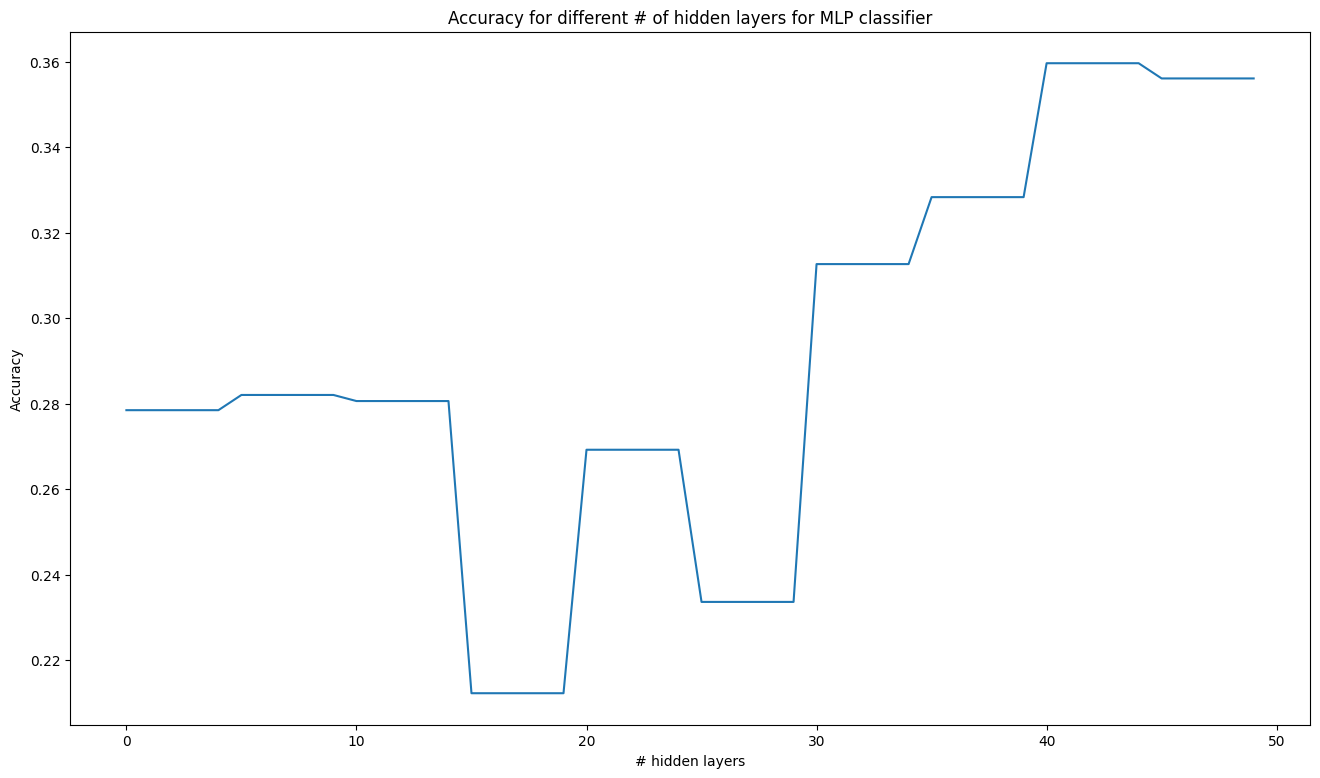

In [22]:
# Tuning for the value of the hidden layers
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                            test_size=0.10)
                                                            '''
hlayers = [40, 50, 60, 70, 80]
#hlayers = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80]:
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
mlp_scores = []
runs = []
index = 0

for h_layer in hlayers:
    for alpha in alphas:
            mlp_clf = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(h_layer,), 
                            random_state=1)
            mlp_clf.fit(X_train, y_train)
            mlp_scores.append(np.asarray(cross_val_score(mlp_clf, X_validate, y_validate, 
                                                         cv=2)).mean())
            runs.append(index)
            index+=1
    
basic_plot((16,9), runs, mlp_scores, "# hidden layers", "Accuracy", 
           "Accuracy for different # of hidden layers for MLP classifier")

In [21]:
n_hidden_opt = 60
mlp_clf = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(n_hidden_opt,), 
                            random_state=1)
mlp_clf.fit(X_train, y_train)
print(np.asarray(cross_val_score(mlp_clf, X_validate, y_validate, cv=2)).mean())
mlp_predictions = mlp_clf.predict(X_test)

print(mlp_clf.score(X_test, y_test))

if VERSION:
    mlp_precision = precision_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_recall = recall_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_f1 = f1_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_cm = confusion_matrix(y_test, mlp_predictions, labels=labels)
else:
    mlp_precision_fma = precision_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_recall_fma = recall_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_f1_fma = f1_score(y_test, mlp_predictions, average=None, labels=labels)
    mlp_cm_fma = confusion_matrix(y_test, mlp_predictions, labels=labels)
    

0.32834757834757833
0.4185897435897436


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Three
As fifth and last classifier, we used decision three. 

### Parameter tuning
Some tuning (ha un botto di parametri Decision Tree...)

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: Us

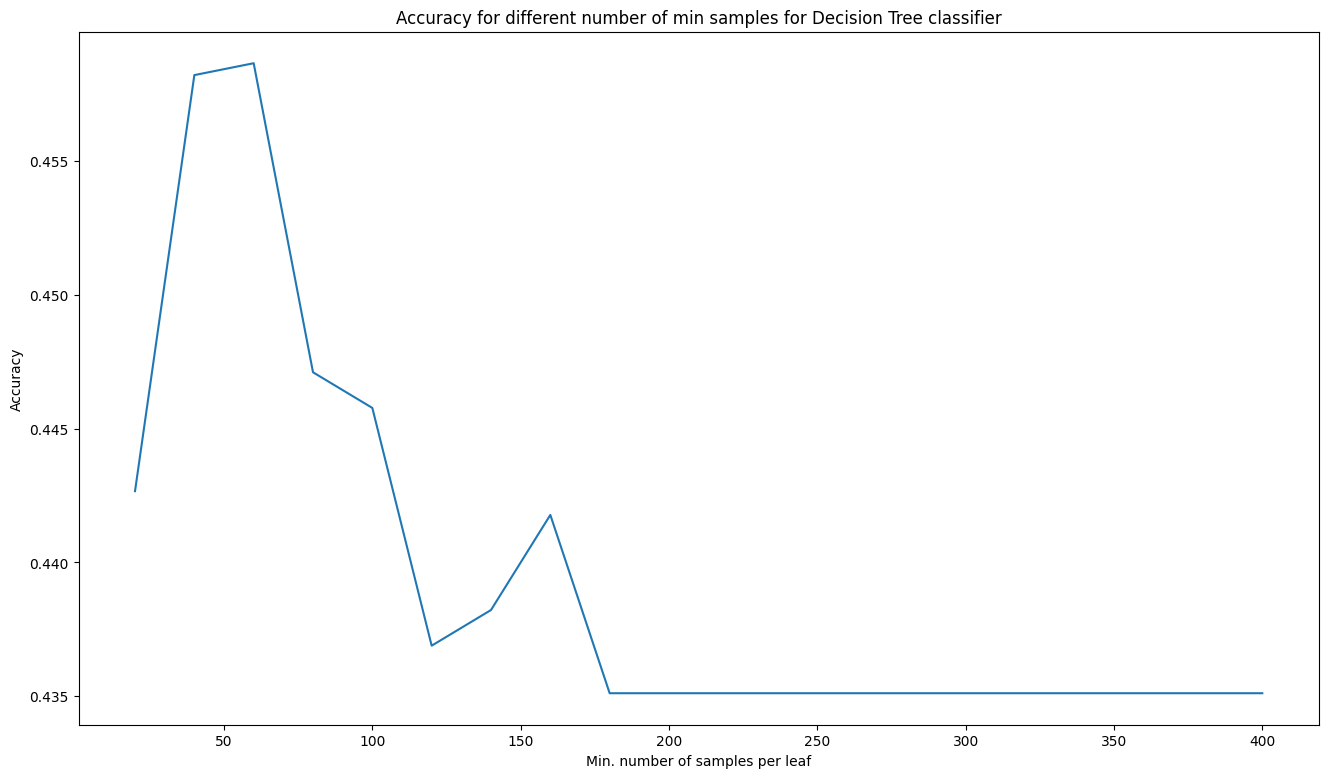

In [73]:
min_samples_leafs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400]
dt_scores = []
for min_samples_leaf in min_samples_leafs:
    dt_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf).fit(X_train, y_train)
    dt_scores.append(np.asarray(cross_val_score(dt_clf, X_validate, y_validate, cv=2)).mean())
basic_plot((16,9), min_samples_leafs, dt_scores, "Min. number of samples per leaf", "Accuracy", 
        "Accuracy for different number of min samples for Decision Tree classifier")

In [76]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=70).fit(X_train, y_train)
print(np.asarray(cross_val_score(dt_clf, X_validate, y_validate, cv=2)).mean())
print(dt_clf.score(X_test, y_test))
dt_predictions = dt_clf.predict(X_test)

if VERSION:
    dt_precision = precision_score(y_test, dt_predictions, average=None, labels=labels)
    dt_recall = recall_score(y_test, dt_predictions, average=None, labels=labels)
    dt_f1 = f1_score(y_test, dt_predictions, average=None, labels=labels)
    dt_cm = confusion_matrix(y_test, dt_predictions, labels=labels)
else:
    dt_precision_fma = precision_score(y_test, dt_predictions, average=None, labels=labels)
    dt_recall_fma = recall_score(y_test, dt_predictions, average=None, labels=labels)
    dt_f1_fma = f1_score(y_test, dt_predictions, average=None, labels=labels)
    dt_cm_fma = confusion_matrix(y_test, dt_predictions, labels=labels)

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4537777777777778
0.53


## Classifiers metrics and comparison
Last, we evaluate performance metrics for the different classifiers and compare the
results obtained.

We compute 4 different metrics for each classifier:

| Metric | Expression|
|:-------- | :-------------------------------------------------: |
| Accuracy | $\tfrac{TN + TP}{TP+FP+TN+FN}$ |
| Precision | $\tfrac{TP}{TP + FP}$ |
| Recall | $\tfrac{TP}{TP + FN}$ |
| F1-score | $2 \cdot \tfrac{Precision \cdot Recal}{Precision + Recal}$ |

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
N.B: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balance.

---------------------------------------------------------------------------------------

Multi Layer Perceptron results: 


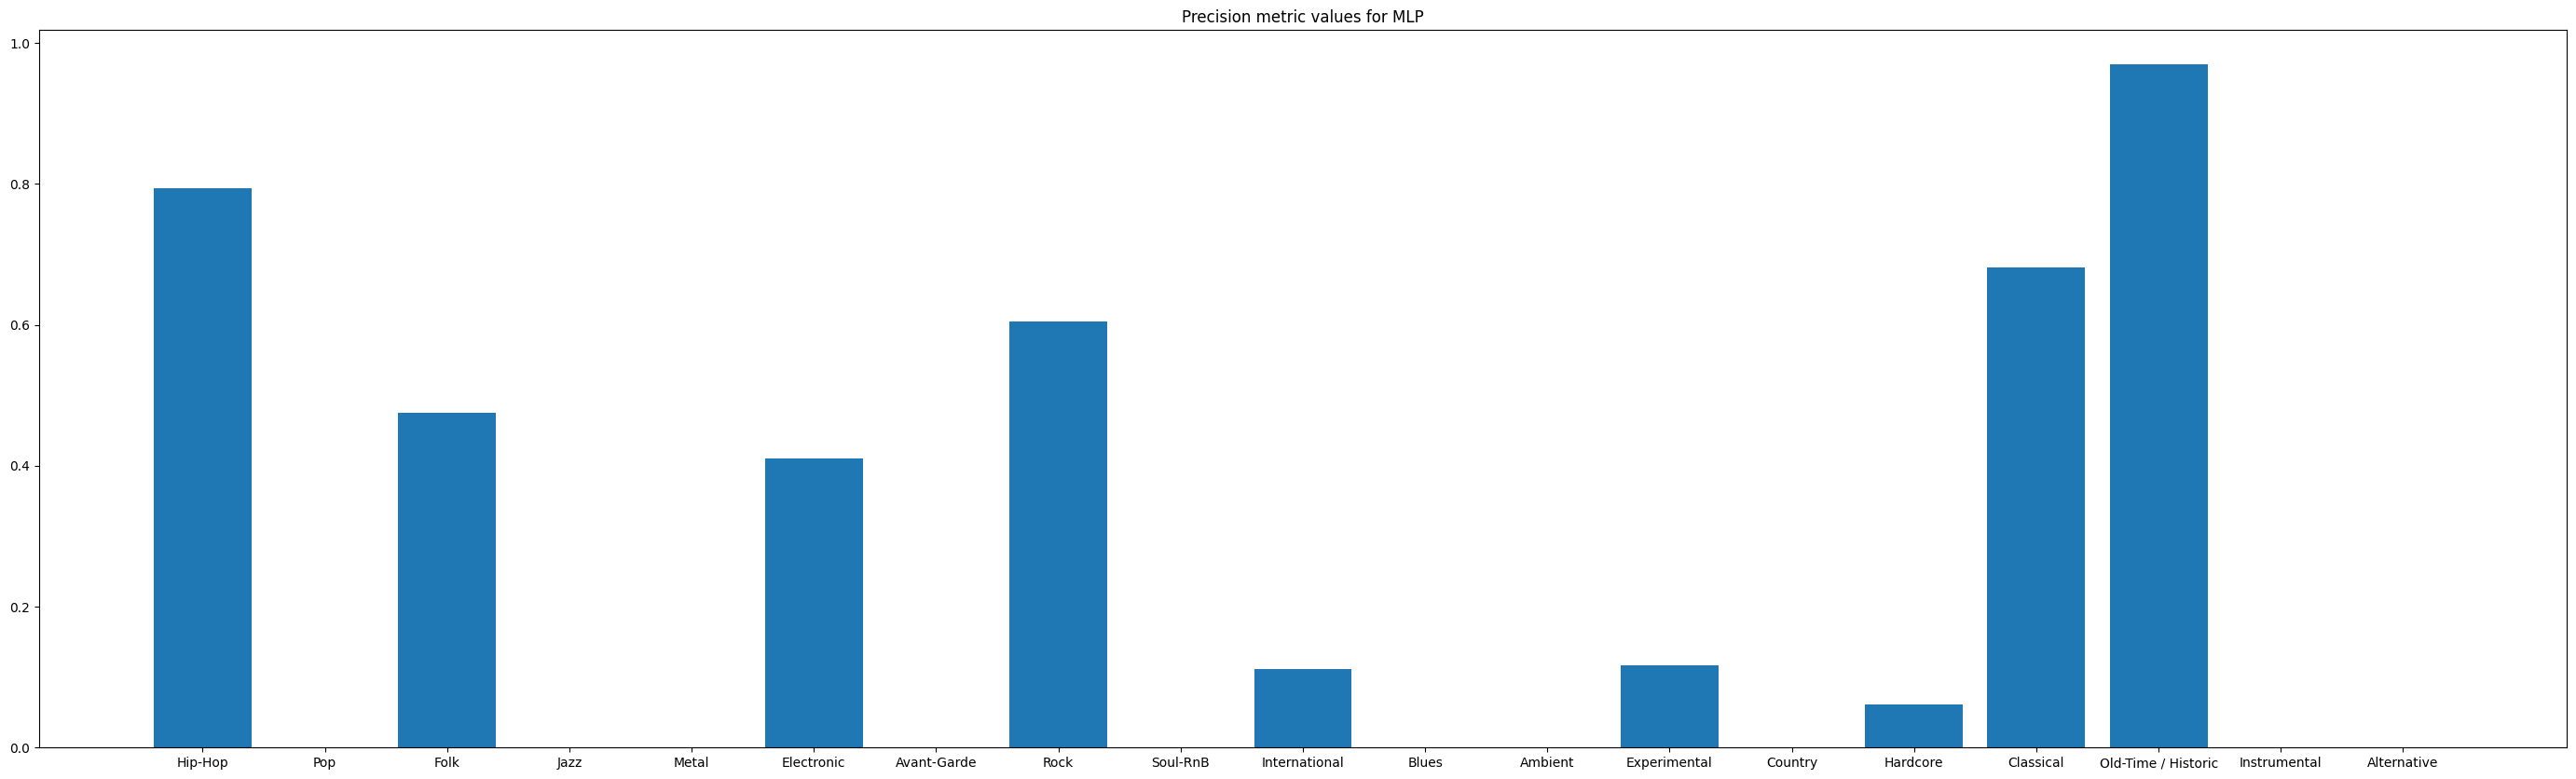

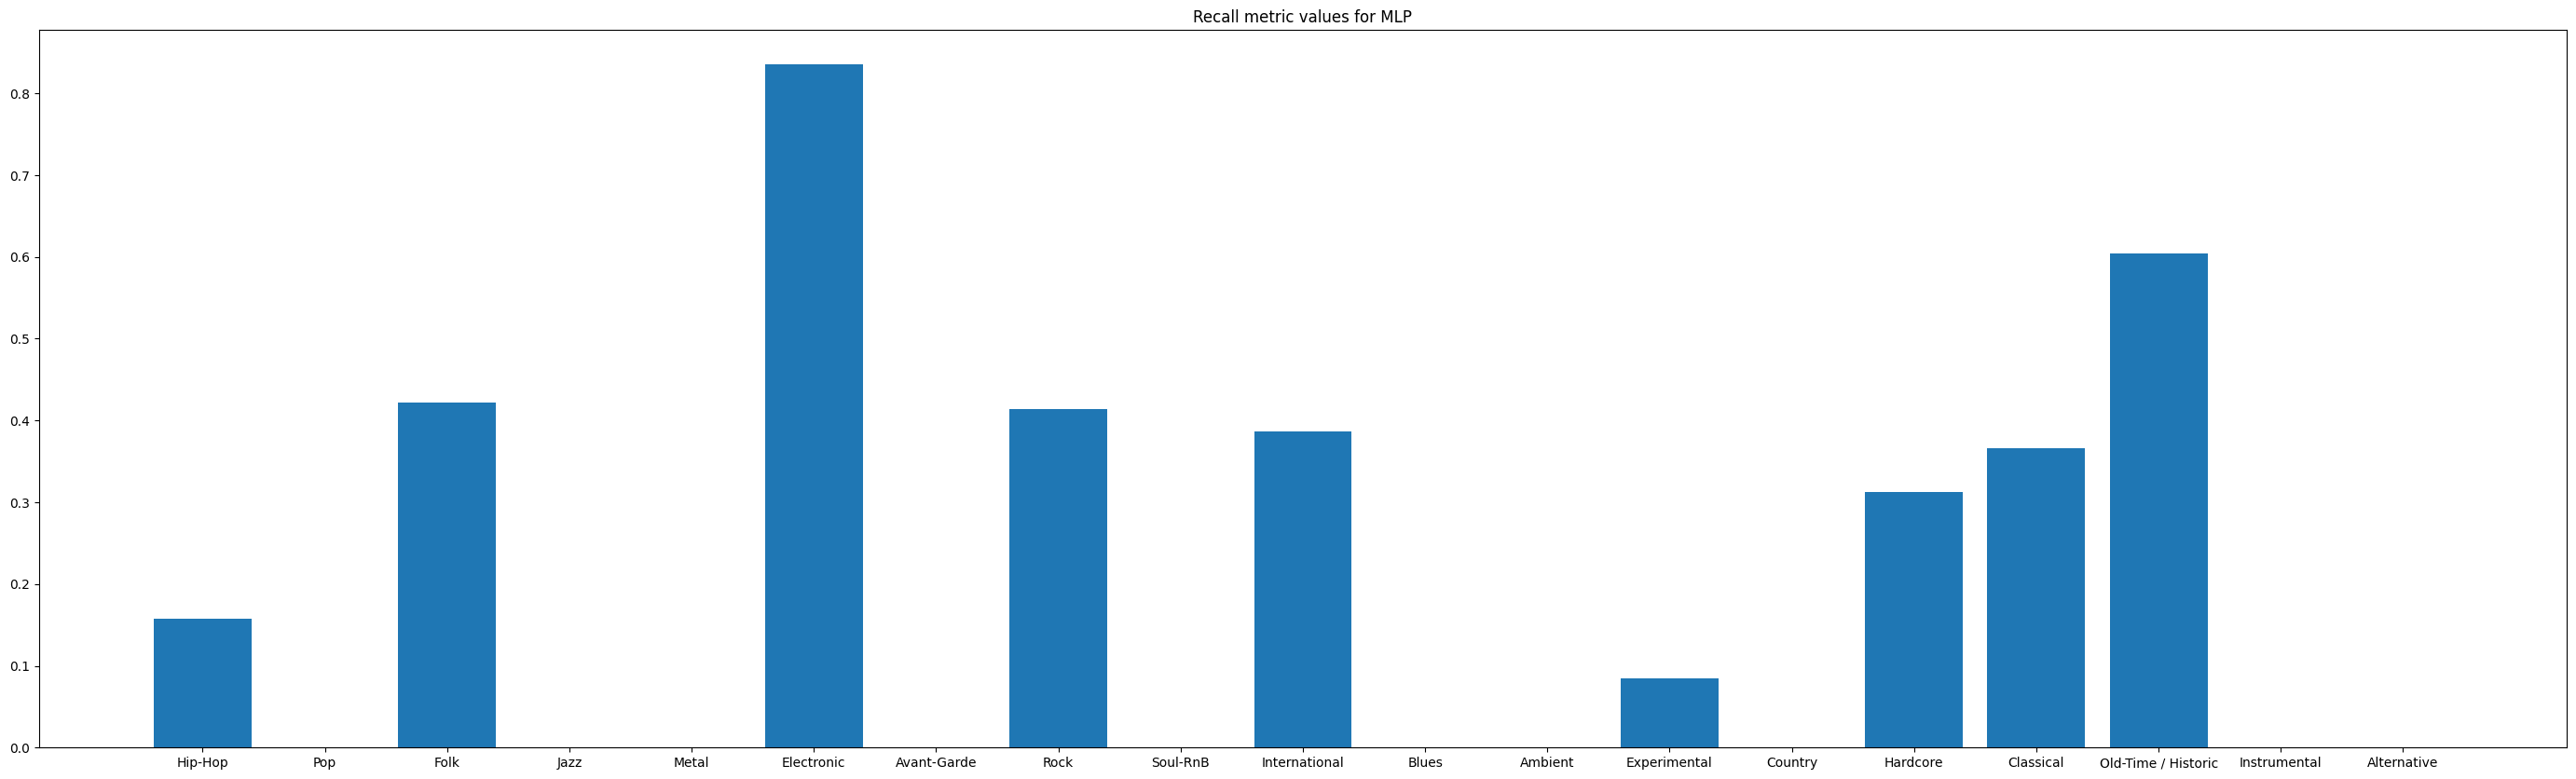

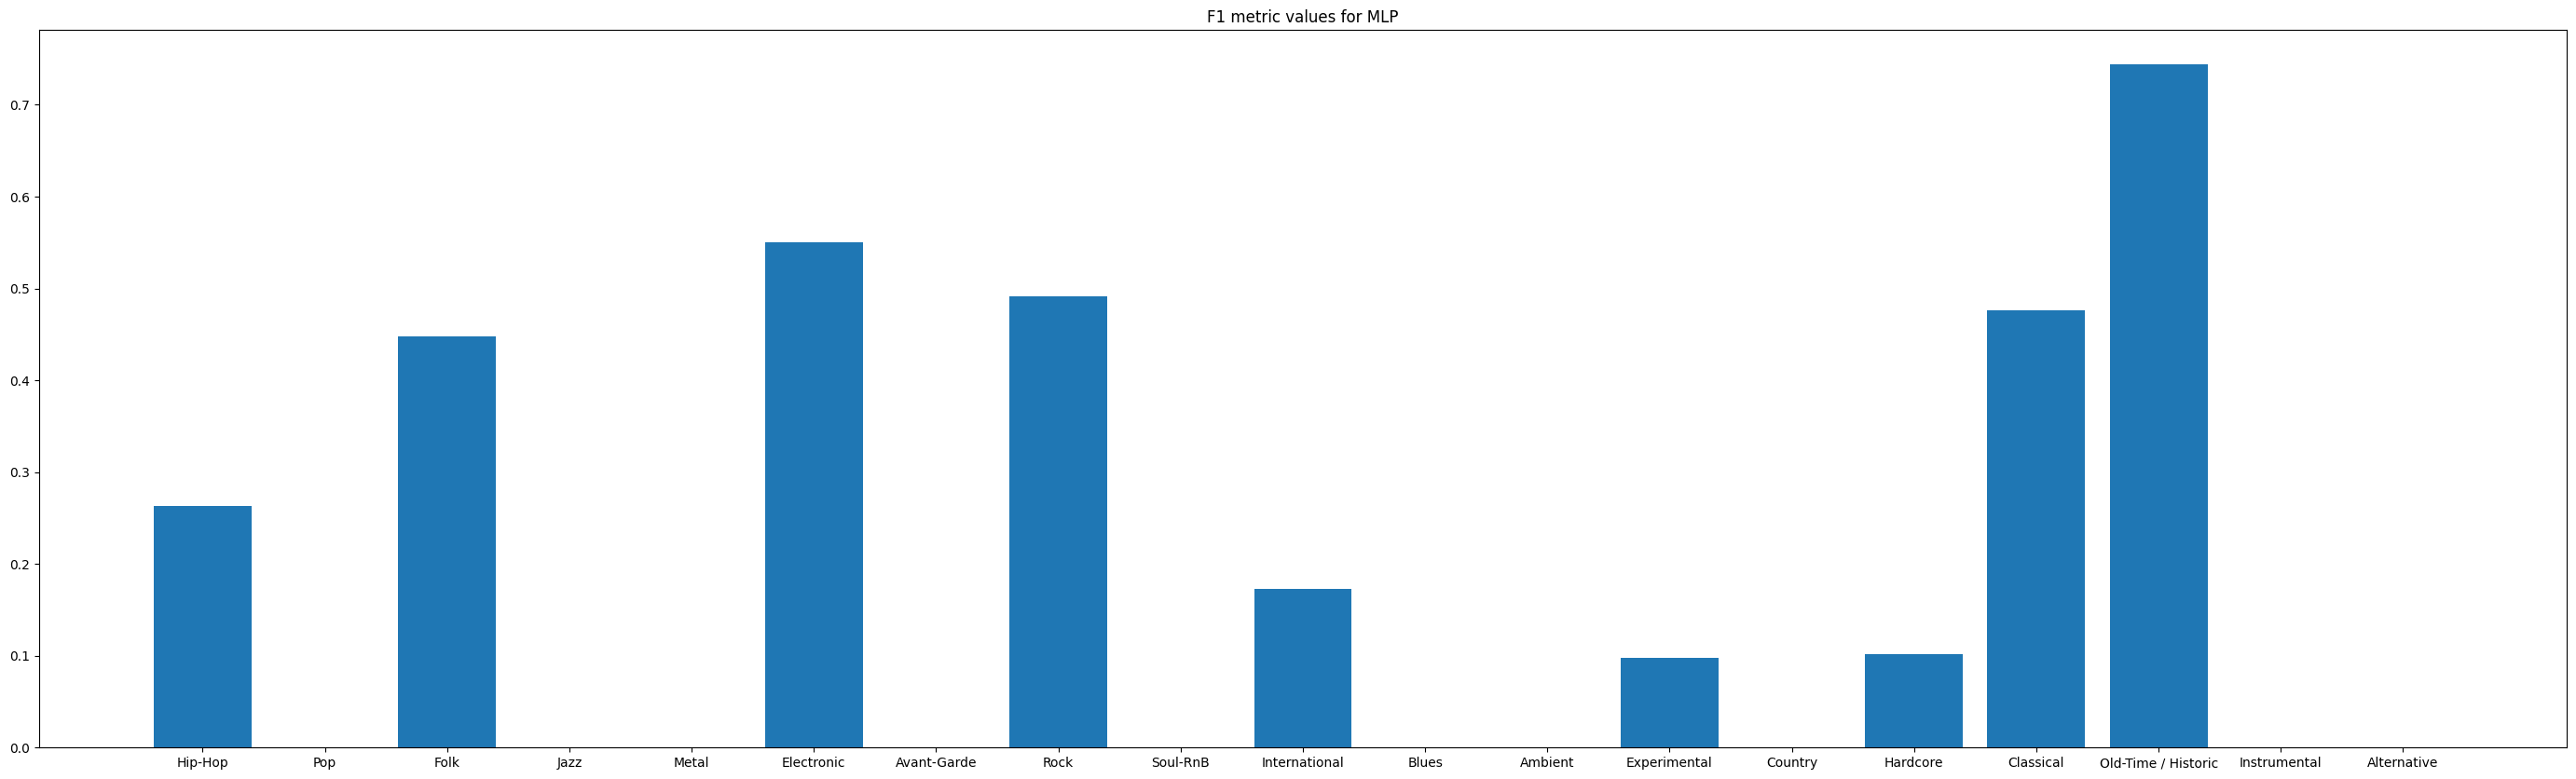

---------------------------------------------------------------------------------------

SVM results:


NameError: name 'svm_precision' is not defined

In [23]:
# TODO: confusion matrix displays wrong label order

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
orig_labels = le.inverse_transform(labels)
print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
bar_plot((35,10), mlp_precision, orig_labels, 'Precision metric values for MLP')
bar_plot((35,10), mlp_recall, orig_labels, 'Recall metric values for MLP')
bar_plot((35,10), mlp_f1, orig_labels, 'F1 metric values for MLP')

print("---------------------------------------------------------------------------------------\n")
print("SVM results:")

bar_plot((25,10), svm_precision, orig_labels, 'Precision metric values for SVM')
bar_plot((25,10), svm_recall, orig_labels, 'Recall metric values for SVM')
bar_plot((25,10), svm_f1, orig_labels, 'F1 metric values for SVM')

'''
cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''


print("---------------------------------------------------------------------------------------\n")

print("kNN results: ")
bar_plot((35,10), knn_precision, orig_labels, 'Precision metric values for kNN')
bar_plot((35,10), knn_recall, orig_labels, 'Recall metric values for kNN')
bar_plot((35,10), knn_f1, orig_labels, 'F1 metric values for kNN')

'''
# Confusion matrix for kNN
#knn_cm = confusion_matrix(y_test, knn_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")

print("Linear Regression results: ")
bar_plot((35,10), lr_precision, orig_labels, 'Precision metric values for LR')
bar_plot((35,10), lr_recall, orig_labels, 'Recall metric values for LR')
bar_plot((35,10), lr_f1, orig_labels, 'F1 metric values for LR')
'''
# Confusion matrix for LR
#lr_cm = confusion_matrix(y_test, lr_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
bar_plot((35,10), mlp_precision, orig_labels, 'Precision metric values for MLP')
bar_plot((35,10), mlp_recall, orig_labels, 'Recall metric values for MLP')
bar_plot((35,10), mlp_f1, orig_labels, 'F1 metric values for MLP')
'''
# Confusion matrix for SVM
#mlp_cm = confusion_matrix(y_test, mlp_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = mlp_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")
print("Decision Tree results: ")
bar_plot((35,10), dt_precision, orig_labels, 'Precision metric values for DT')
bar_plot((35,10), dt_recall, orig_labels, 'Recall metric values for DT')
bar_plot((35,10), dt_f1, orig_labels, 'F1 metric values for DT')

print("---------------------------------------------------------------------------------------\n")

---------------------------------------------------------------------------------------

SVM results:


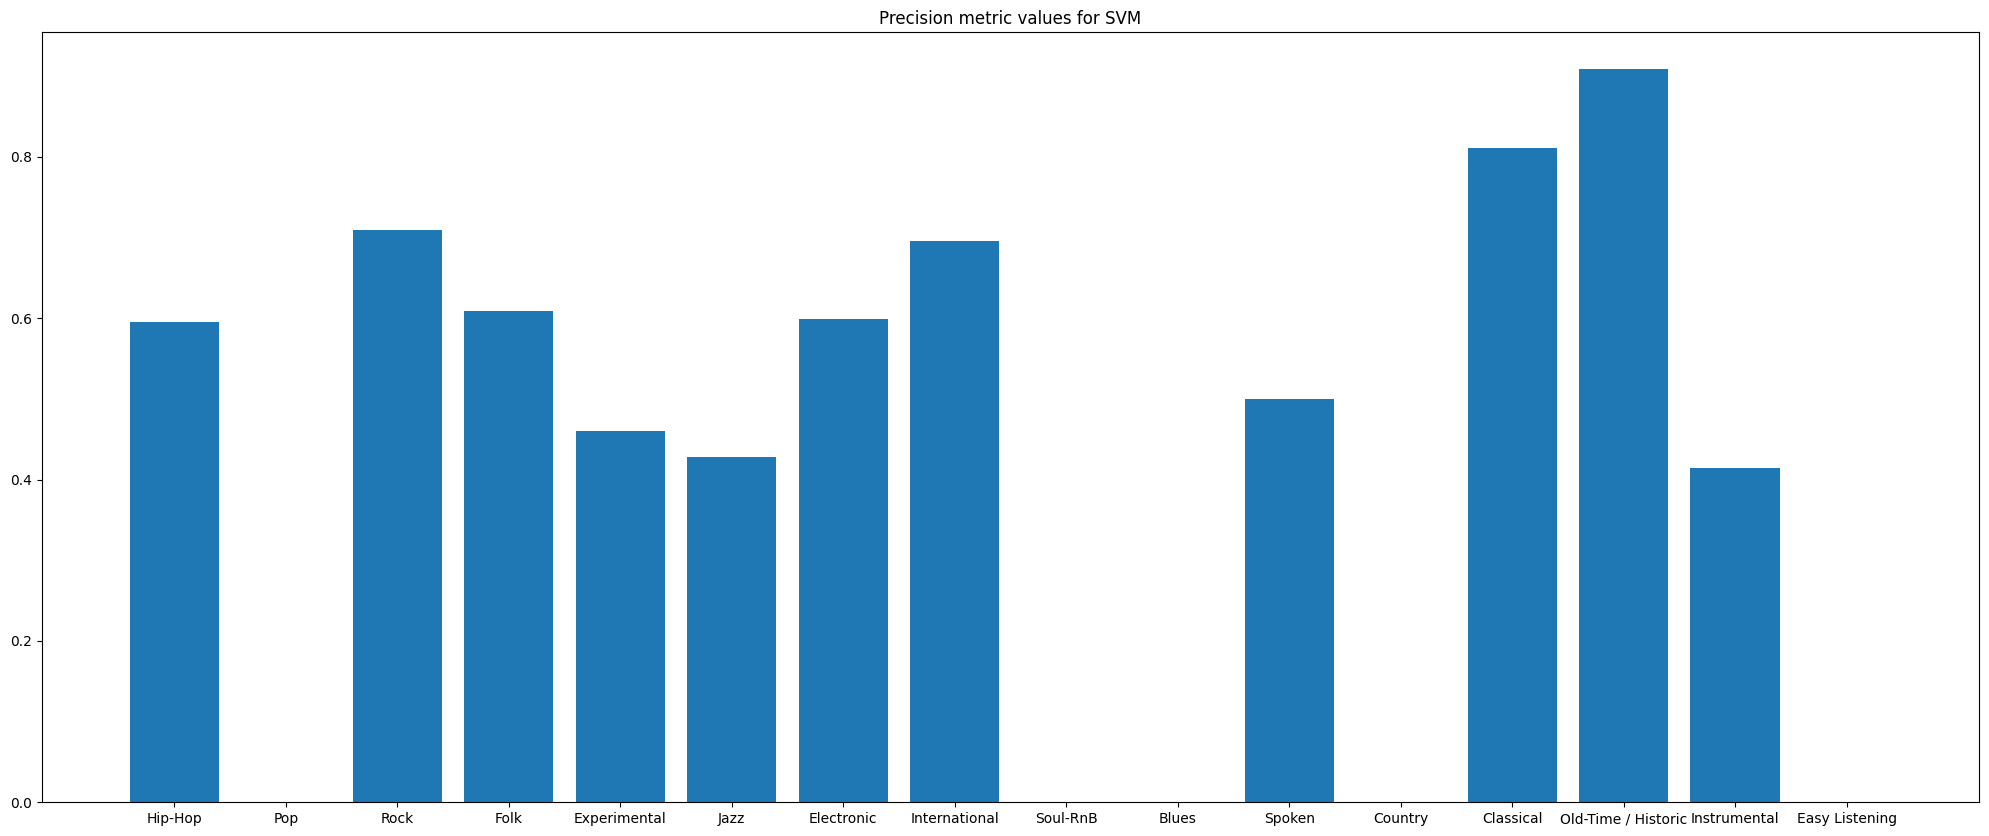

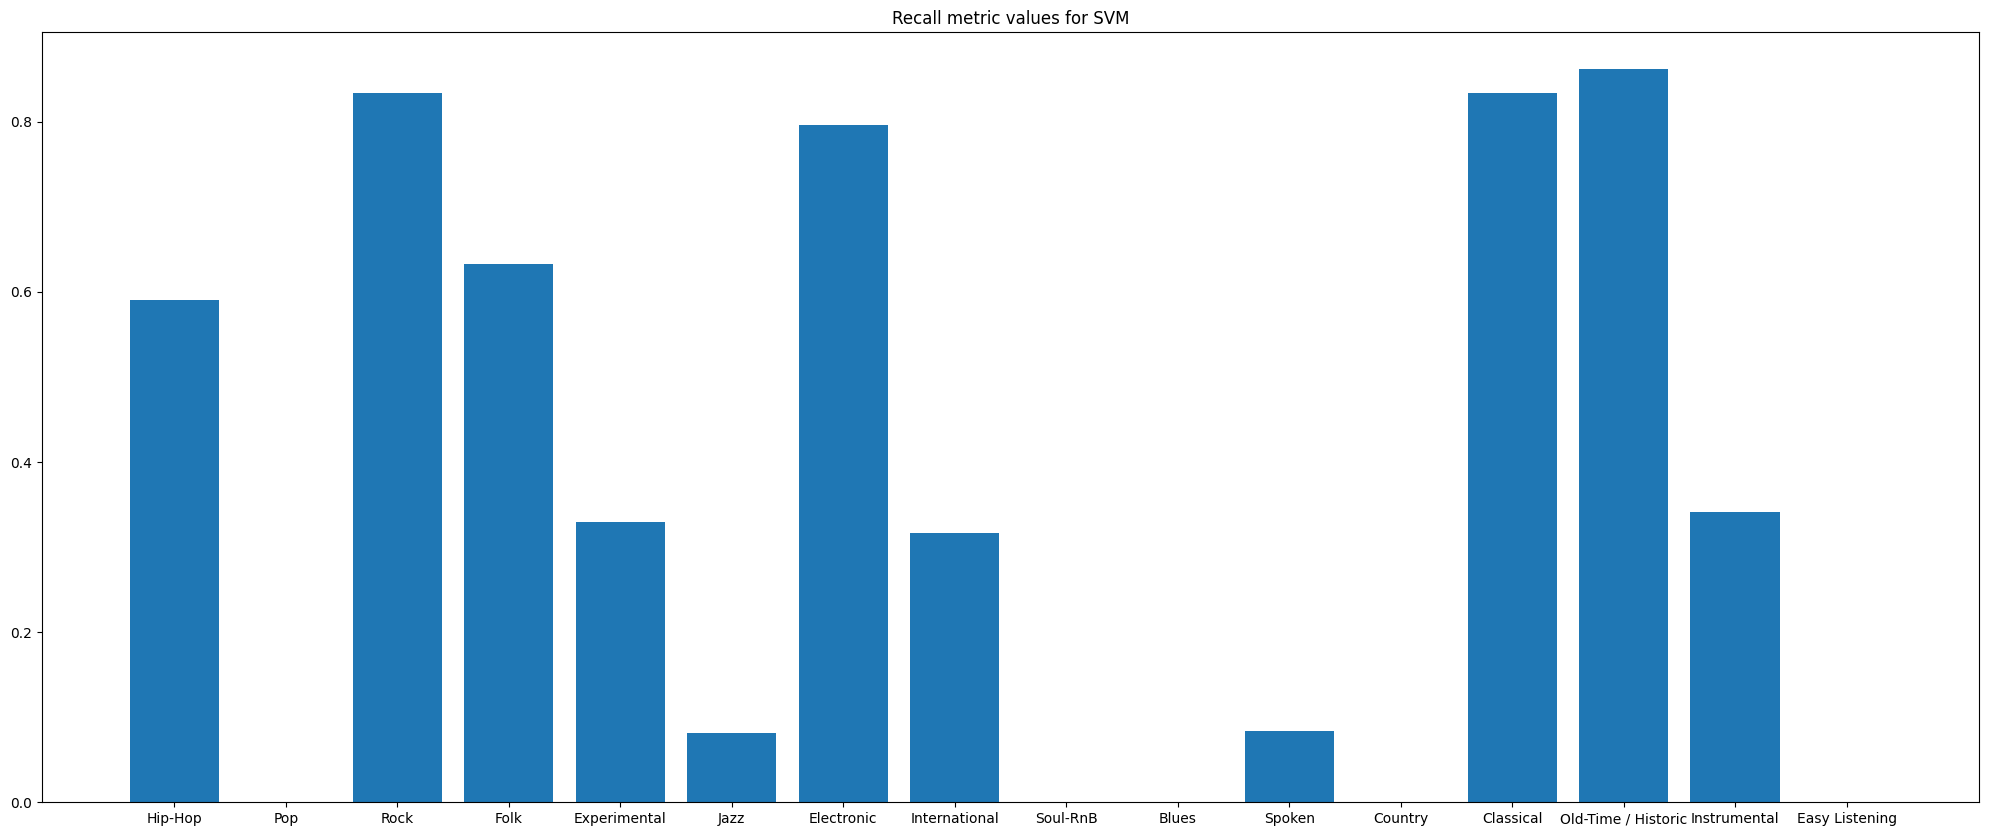

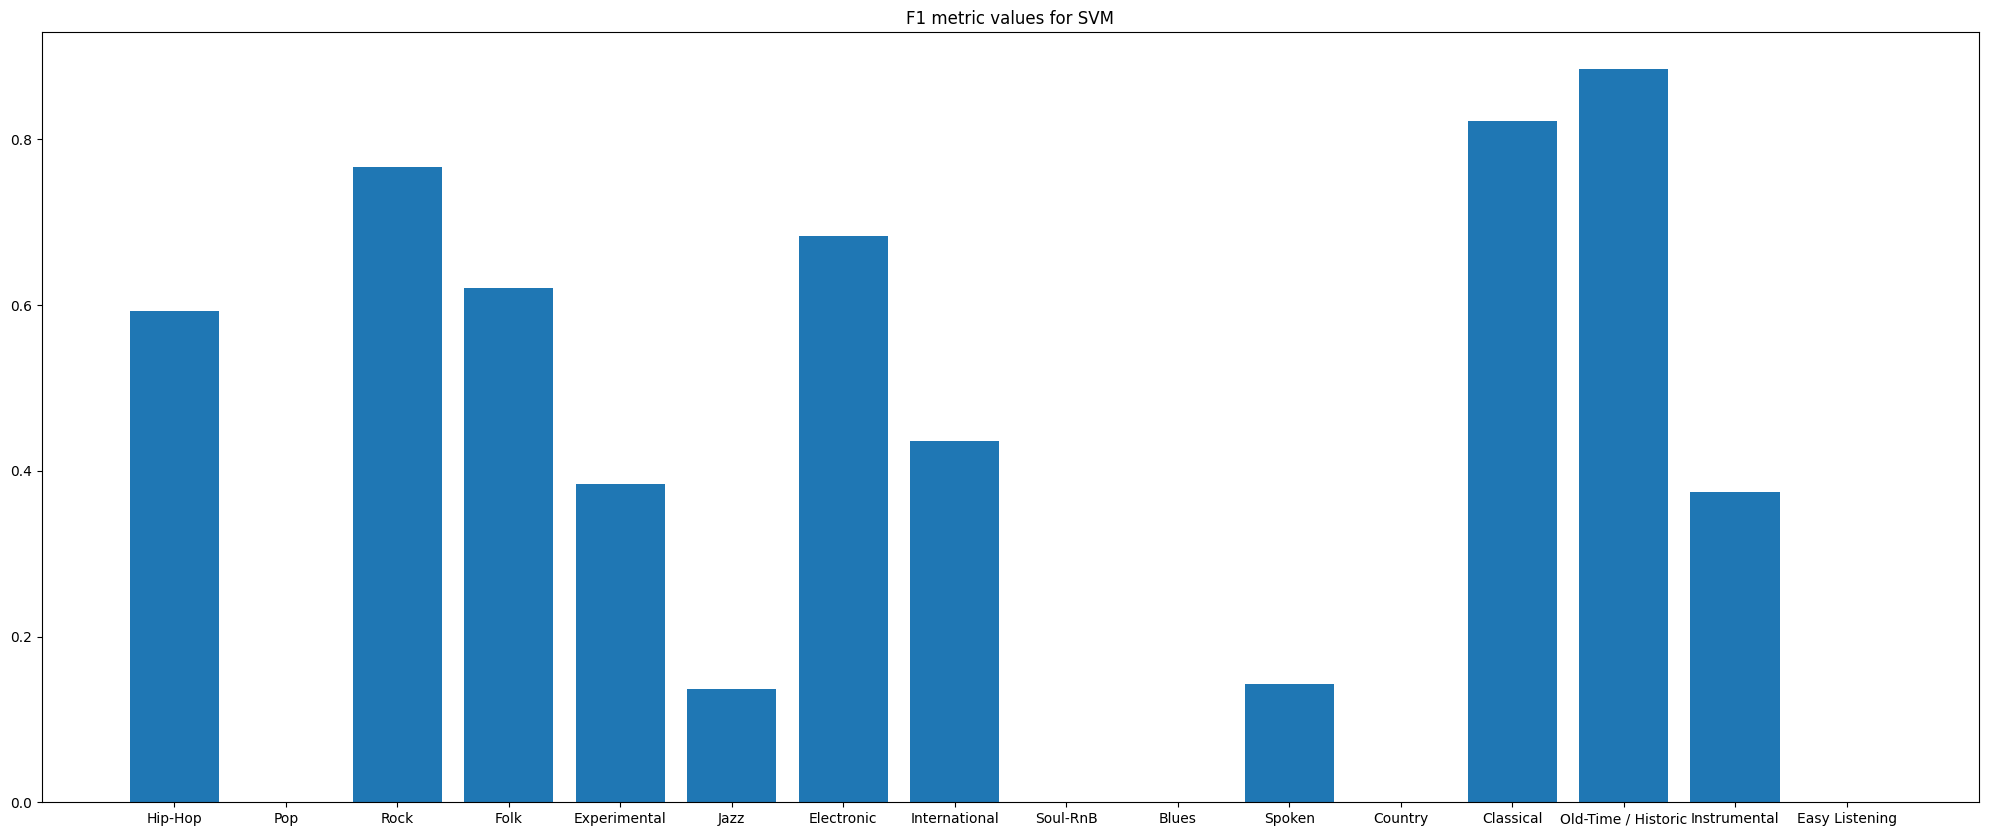

---------------------------------------------------------------------------------------

kNN results: 


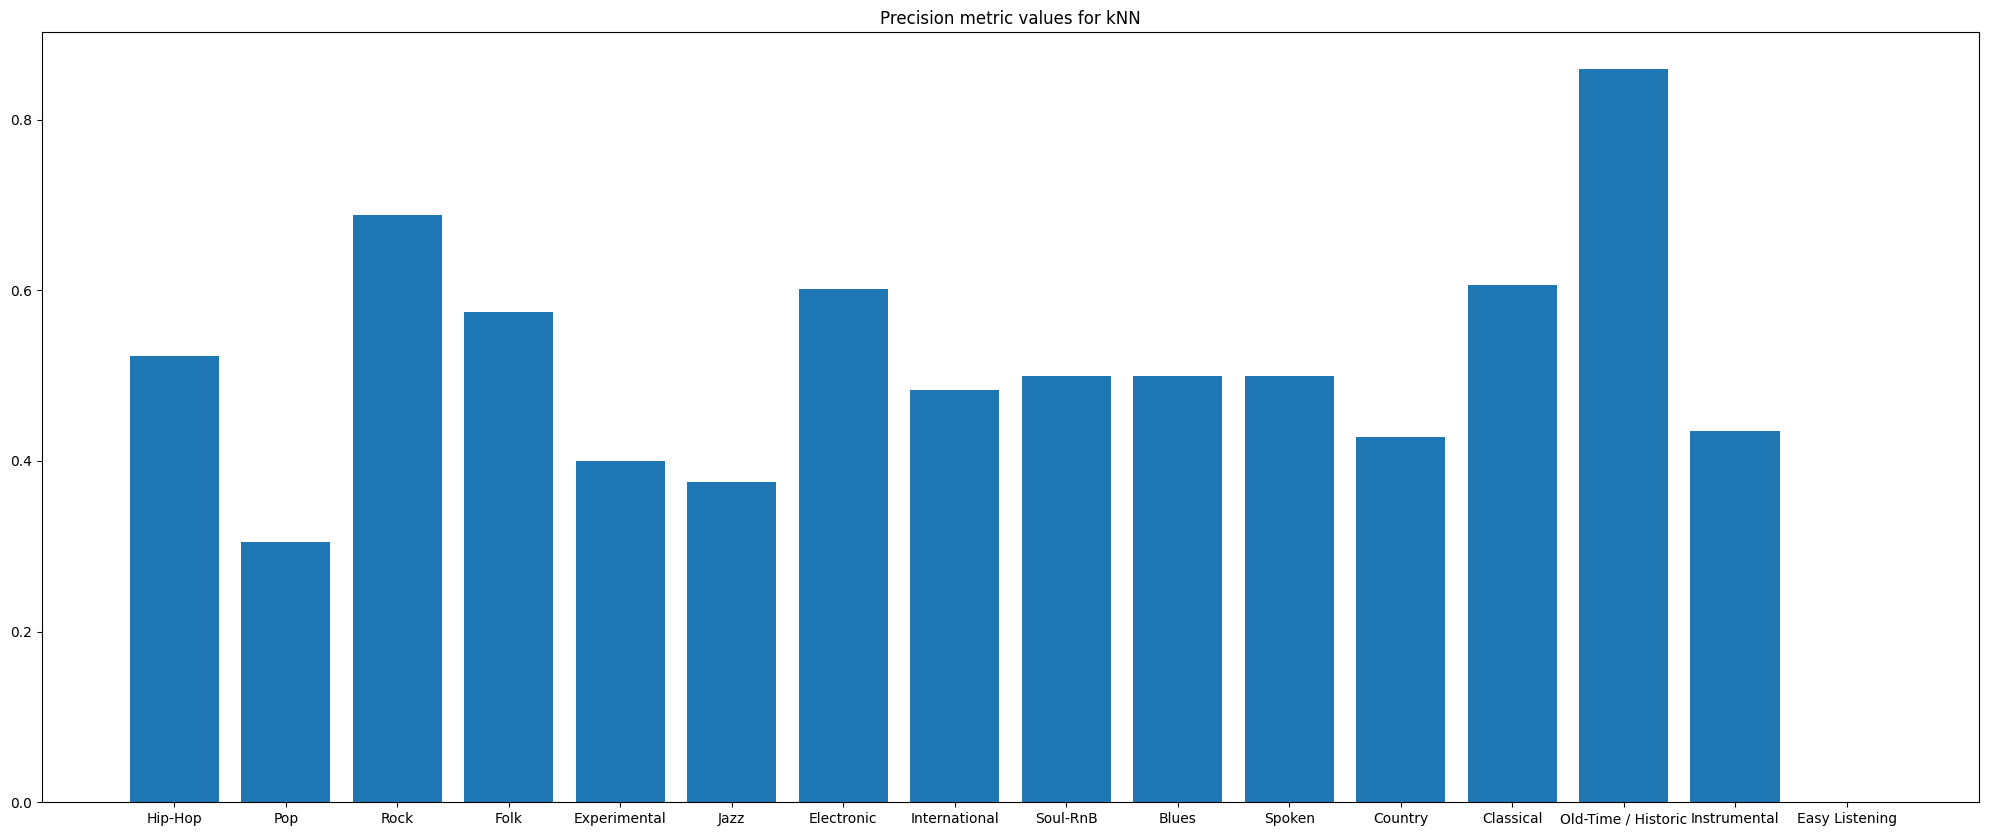

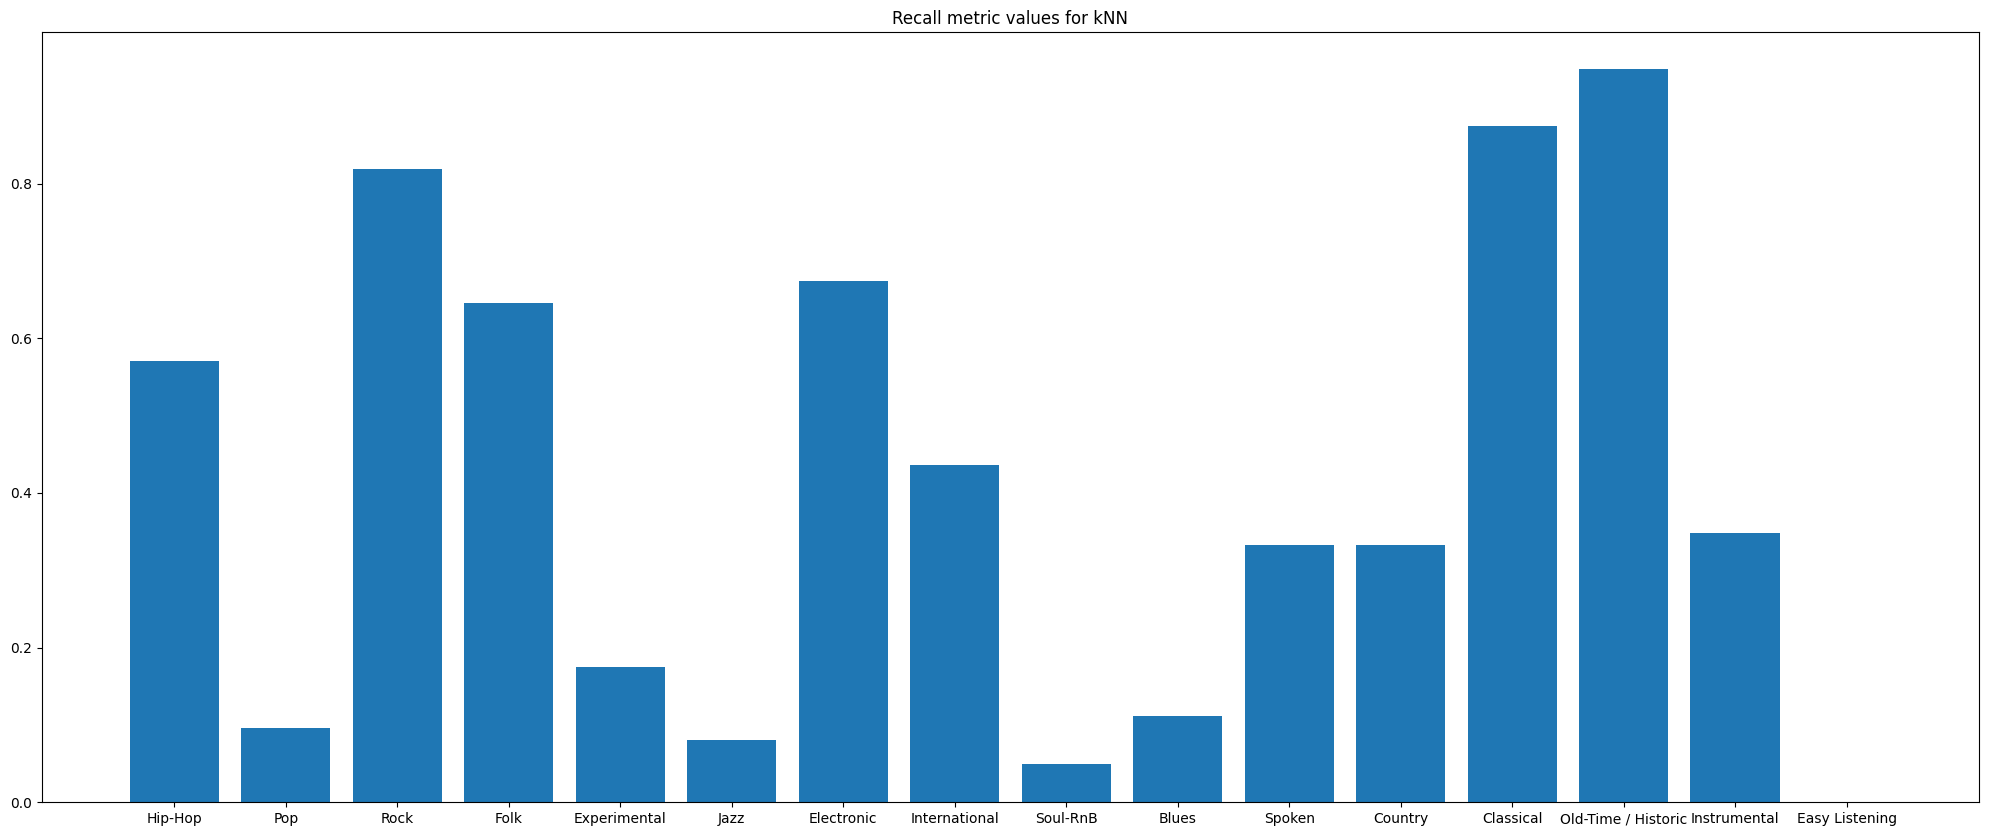

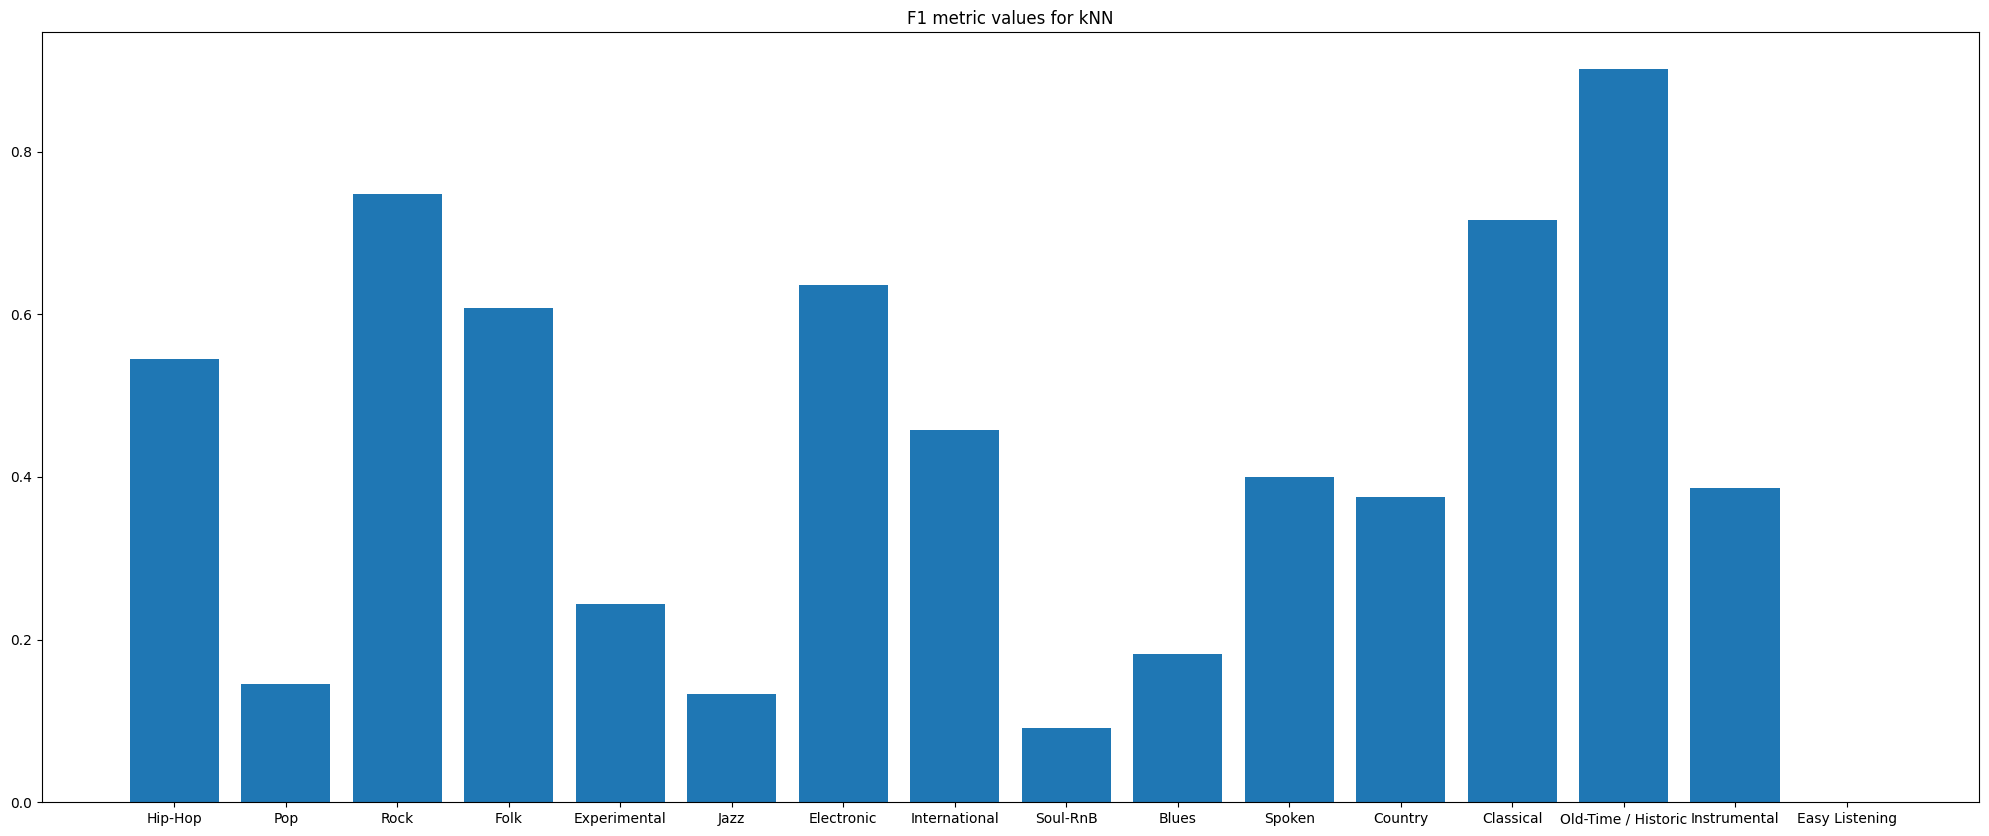

---------------------------------------------------------------------------------------

Linear Regression results: 


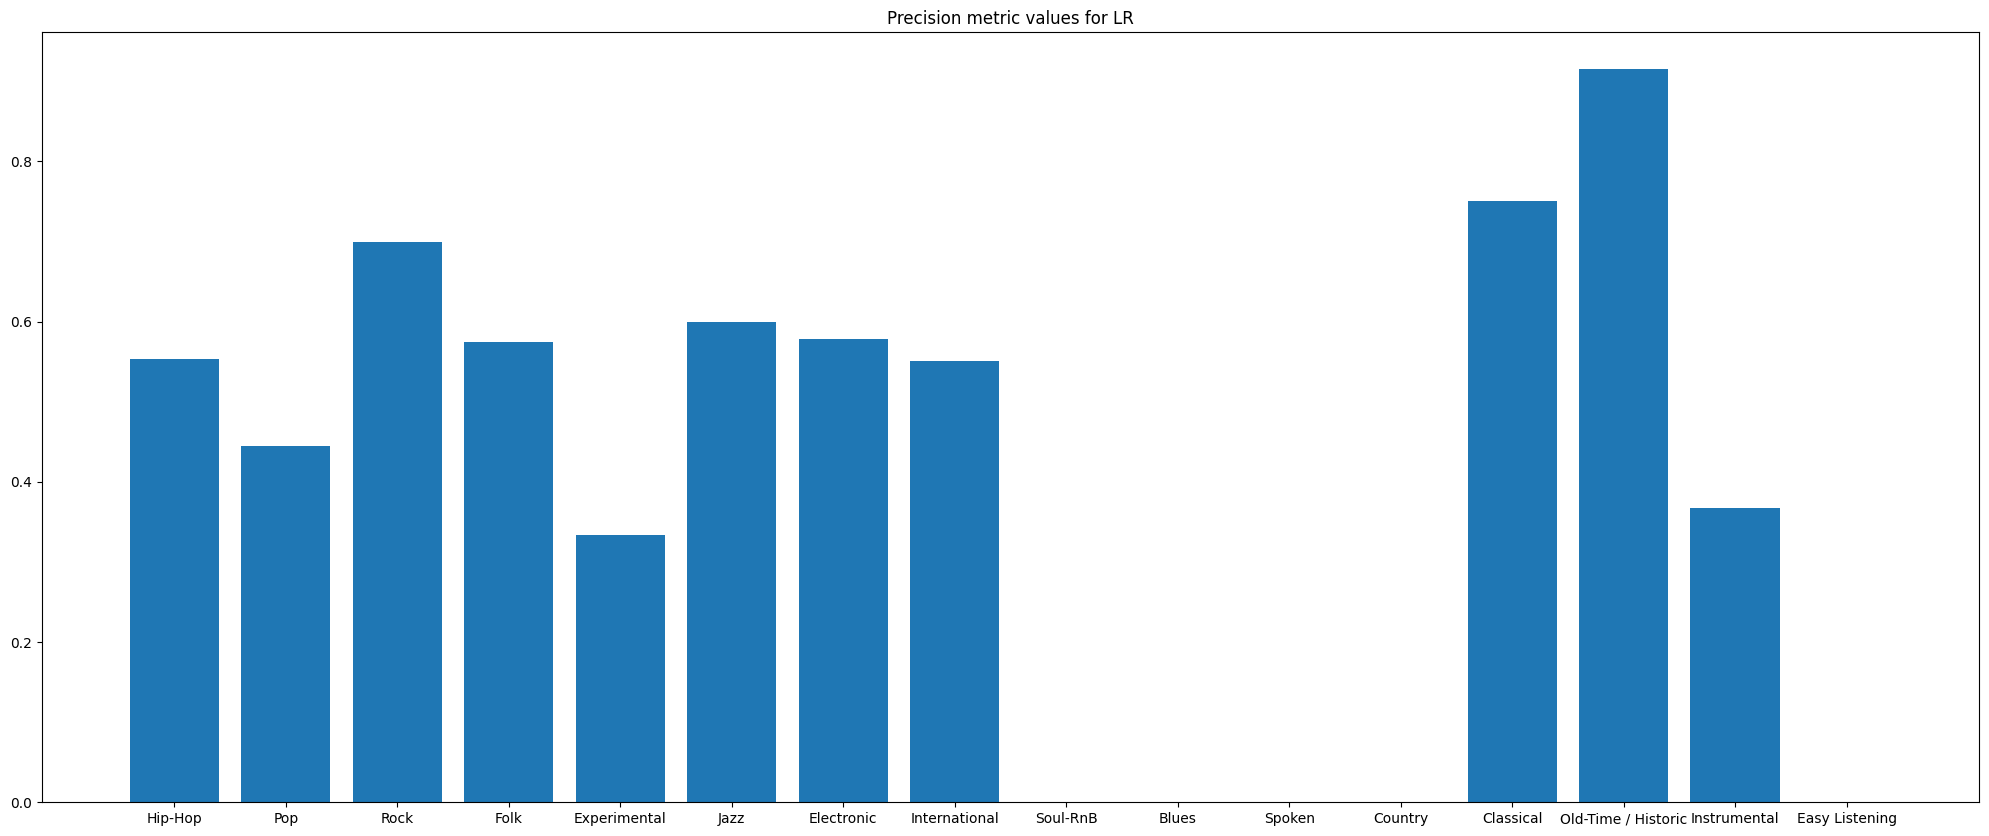

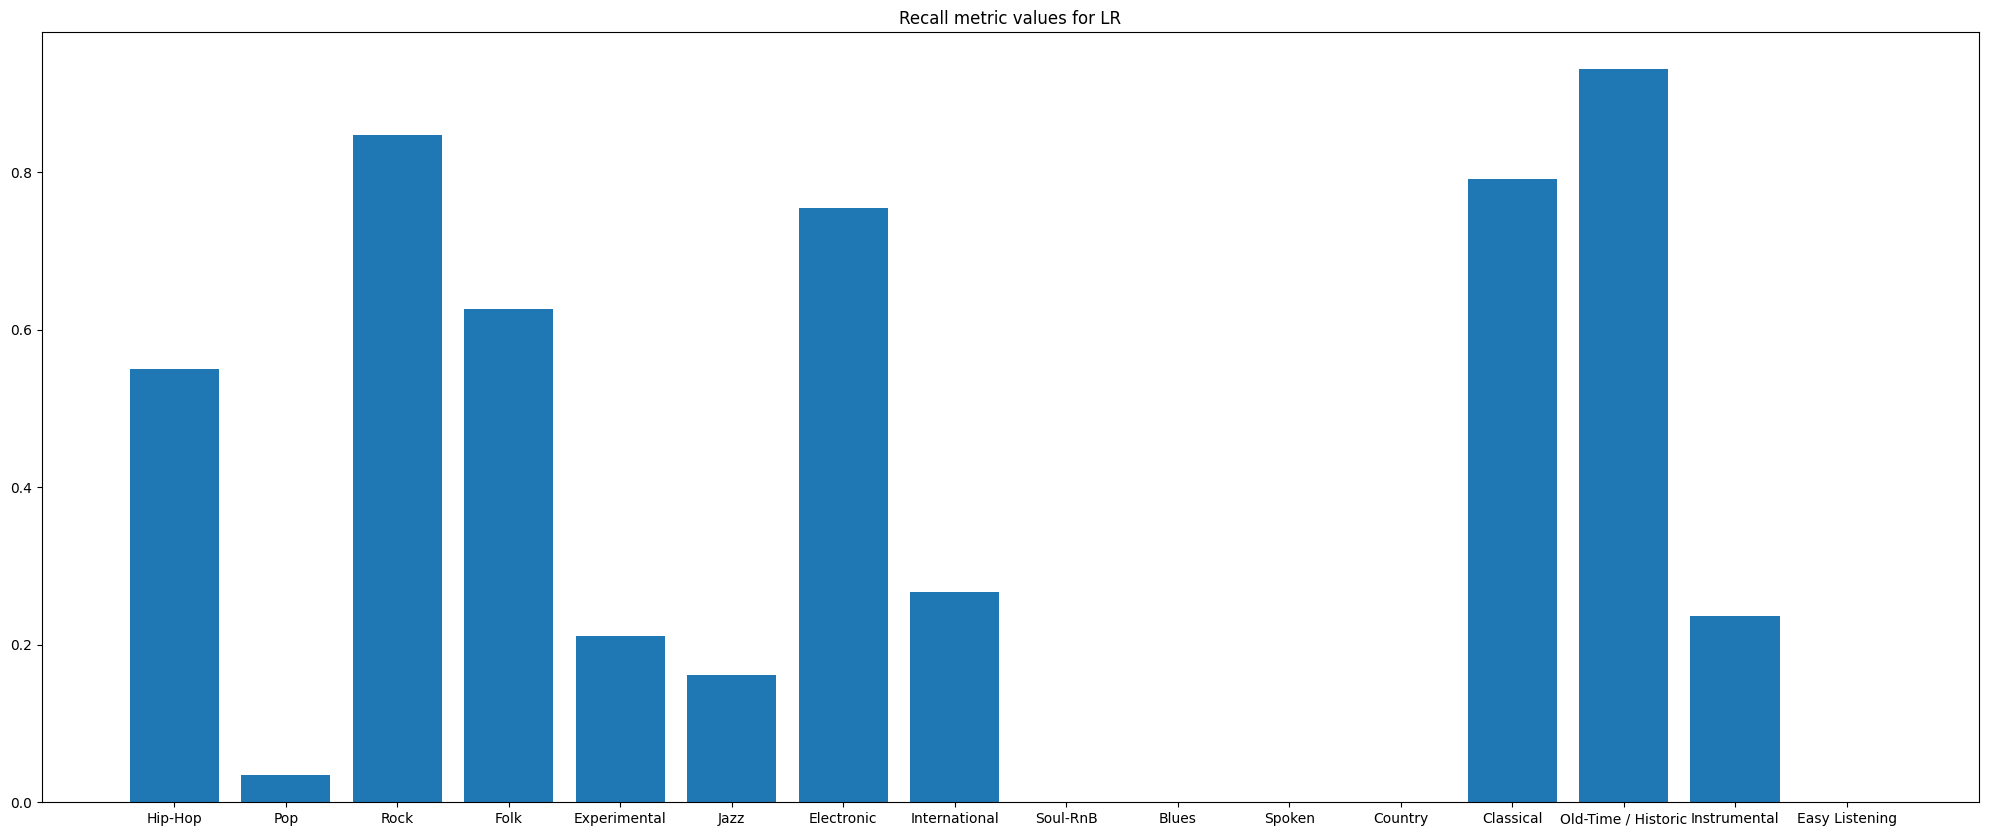

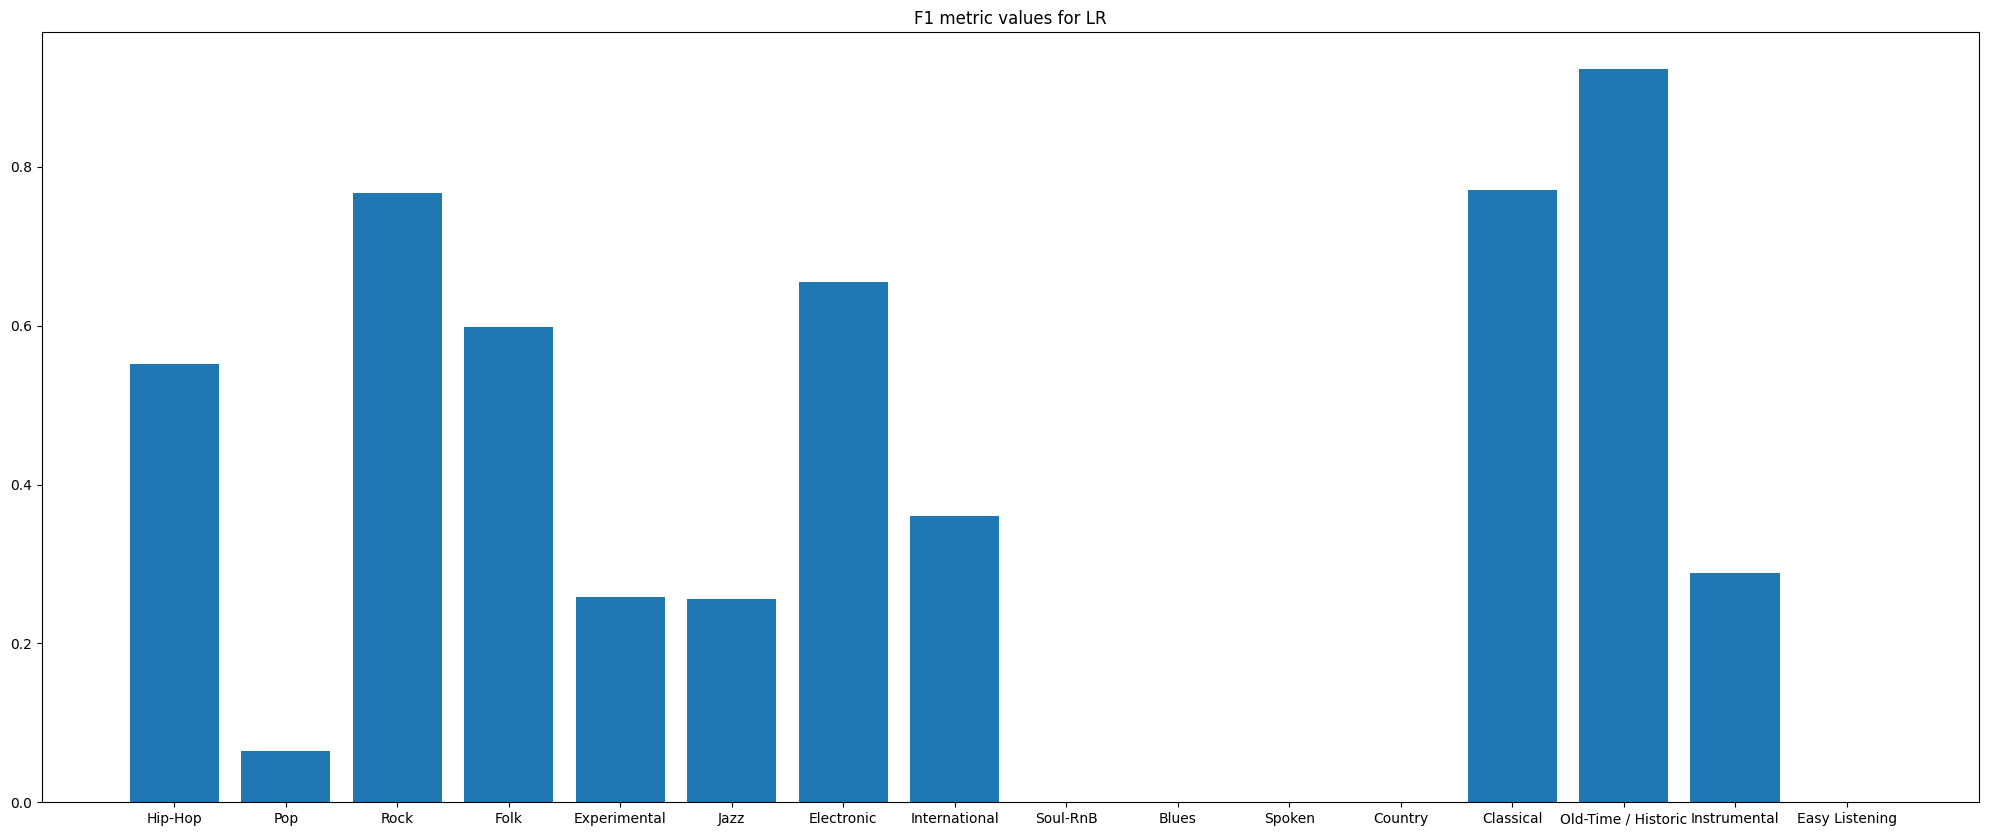

---------------------------------------------------------------------------------------

Multi Layer Perceptron results: 


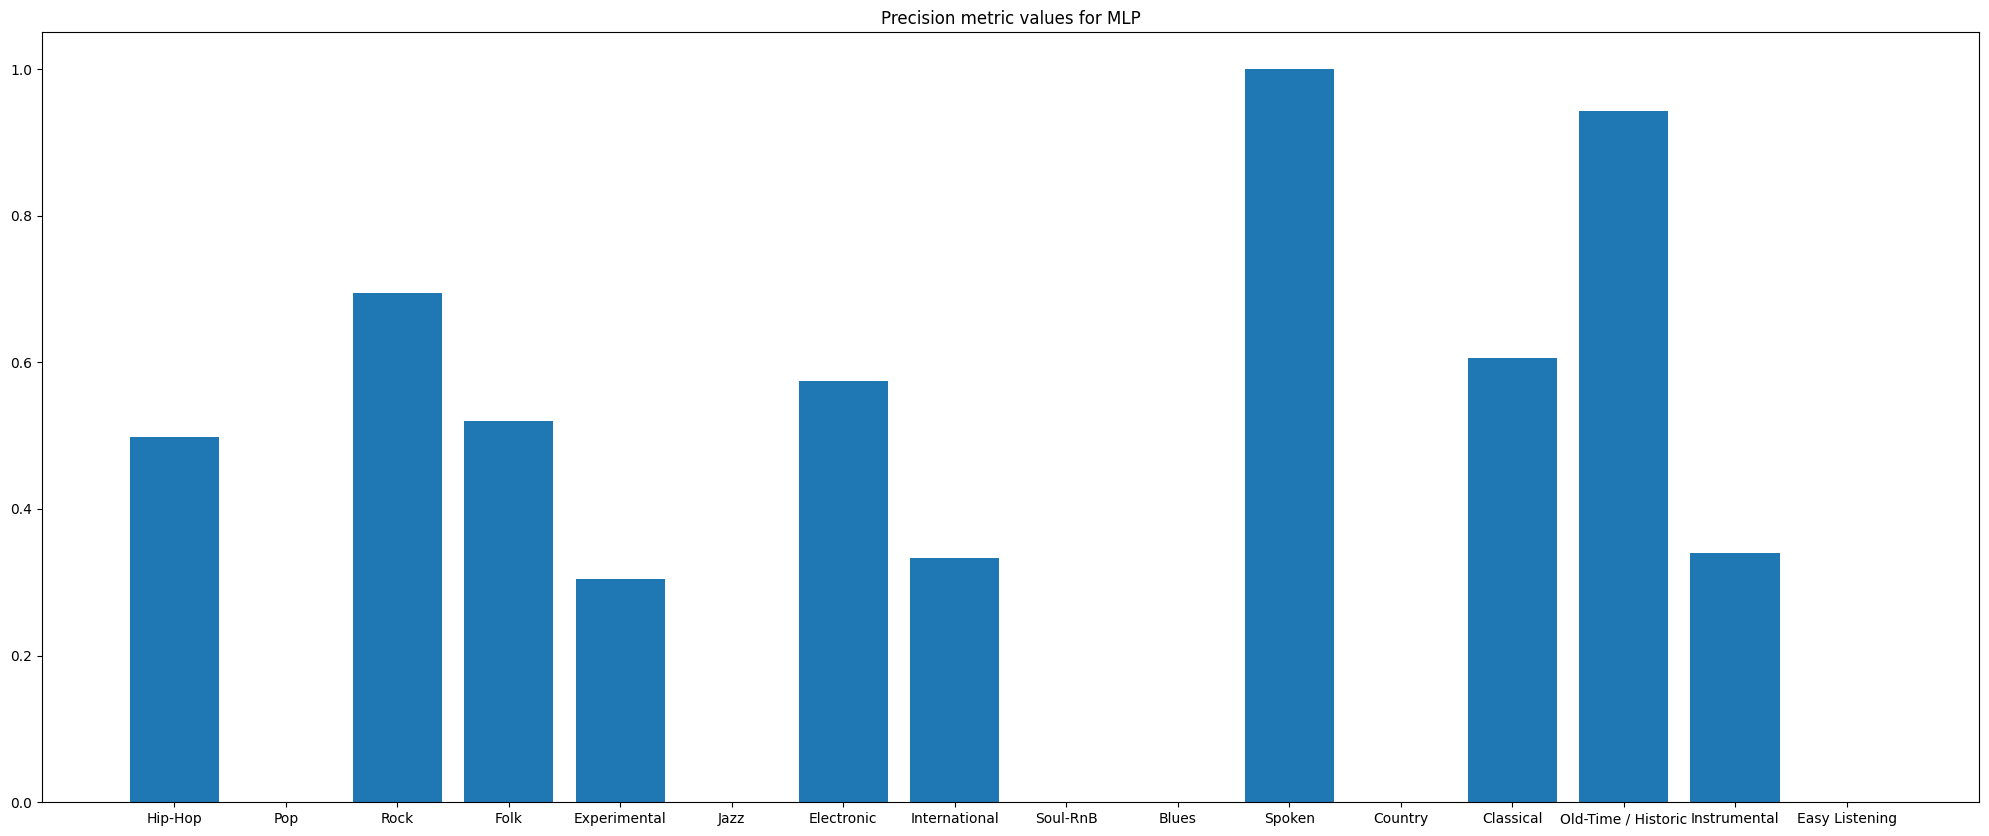

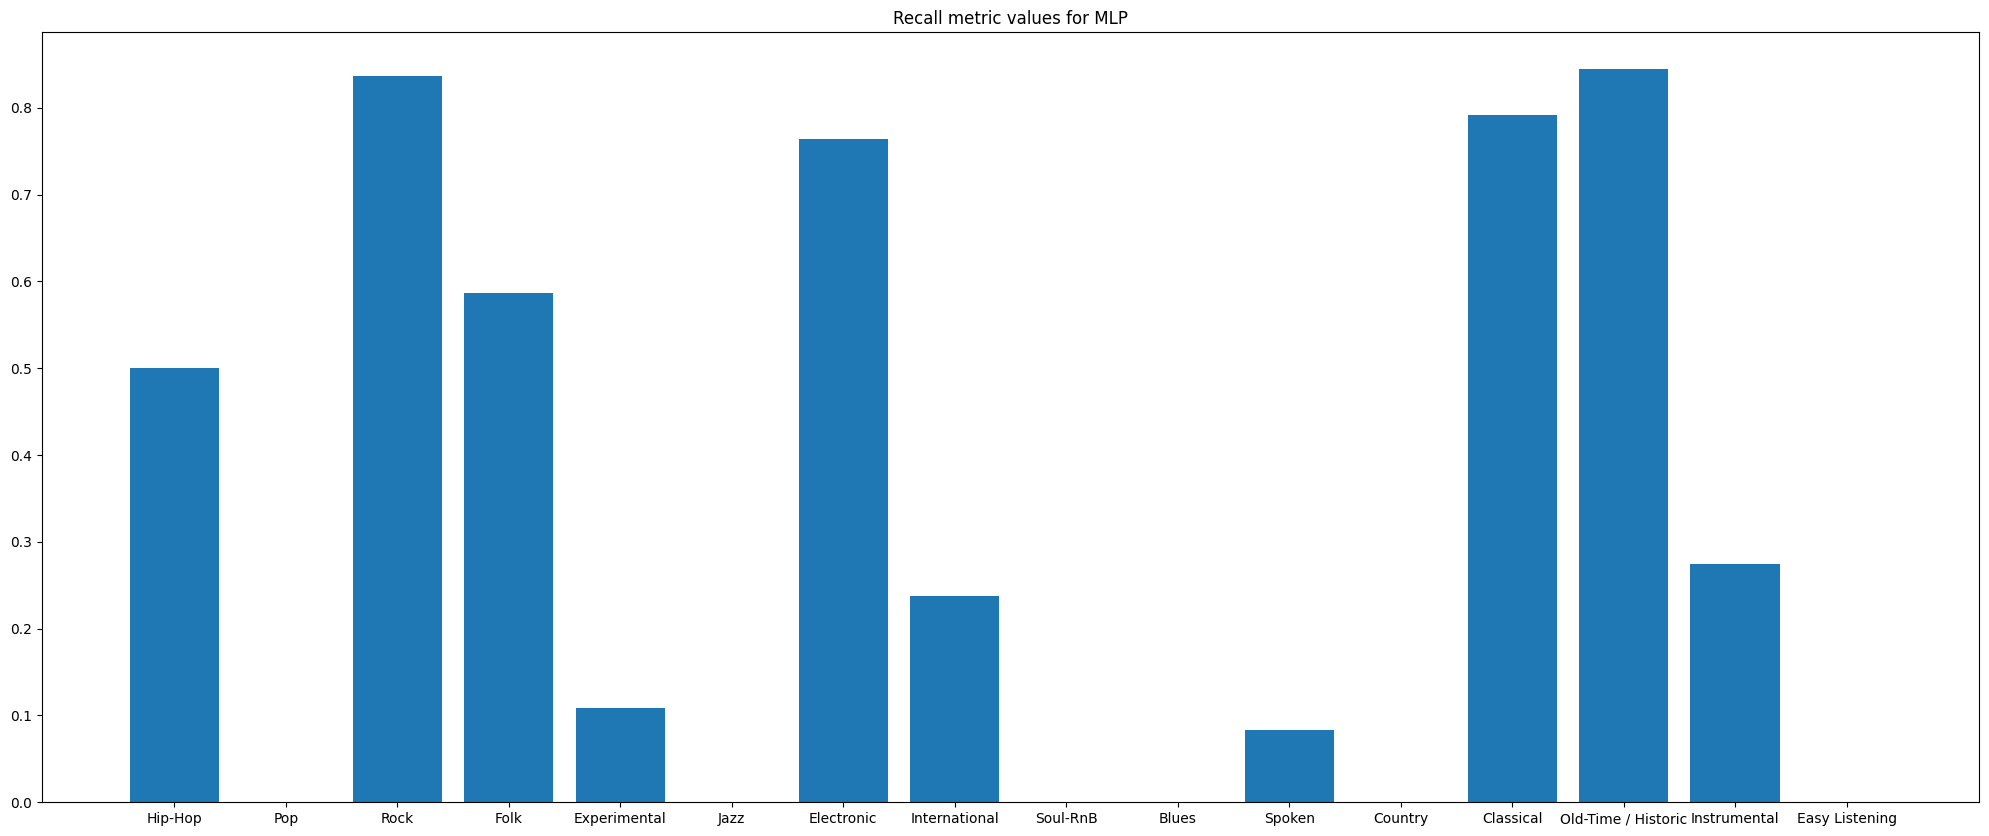

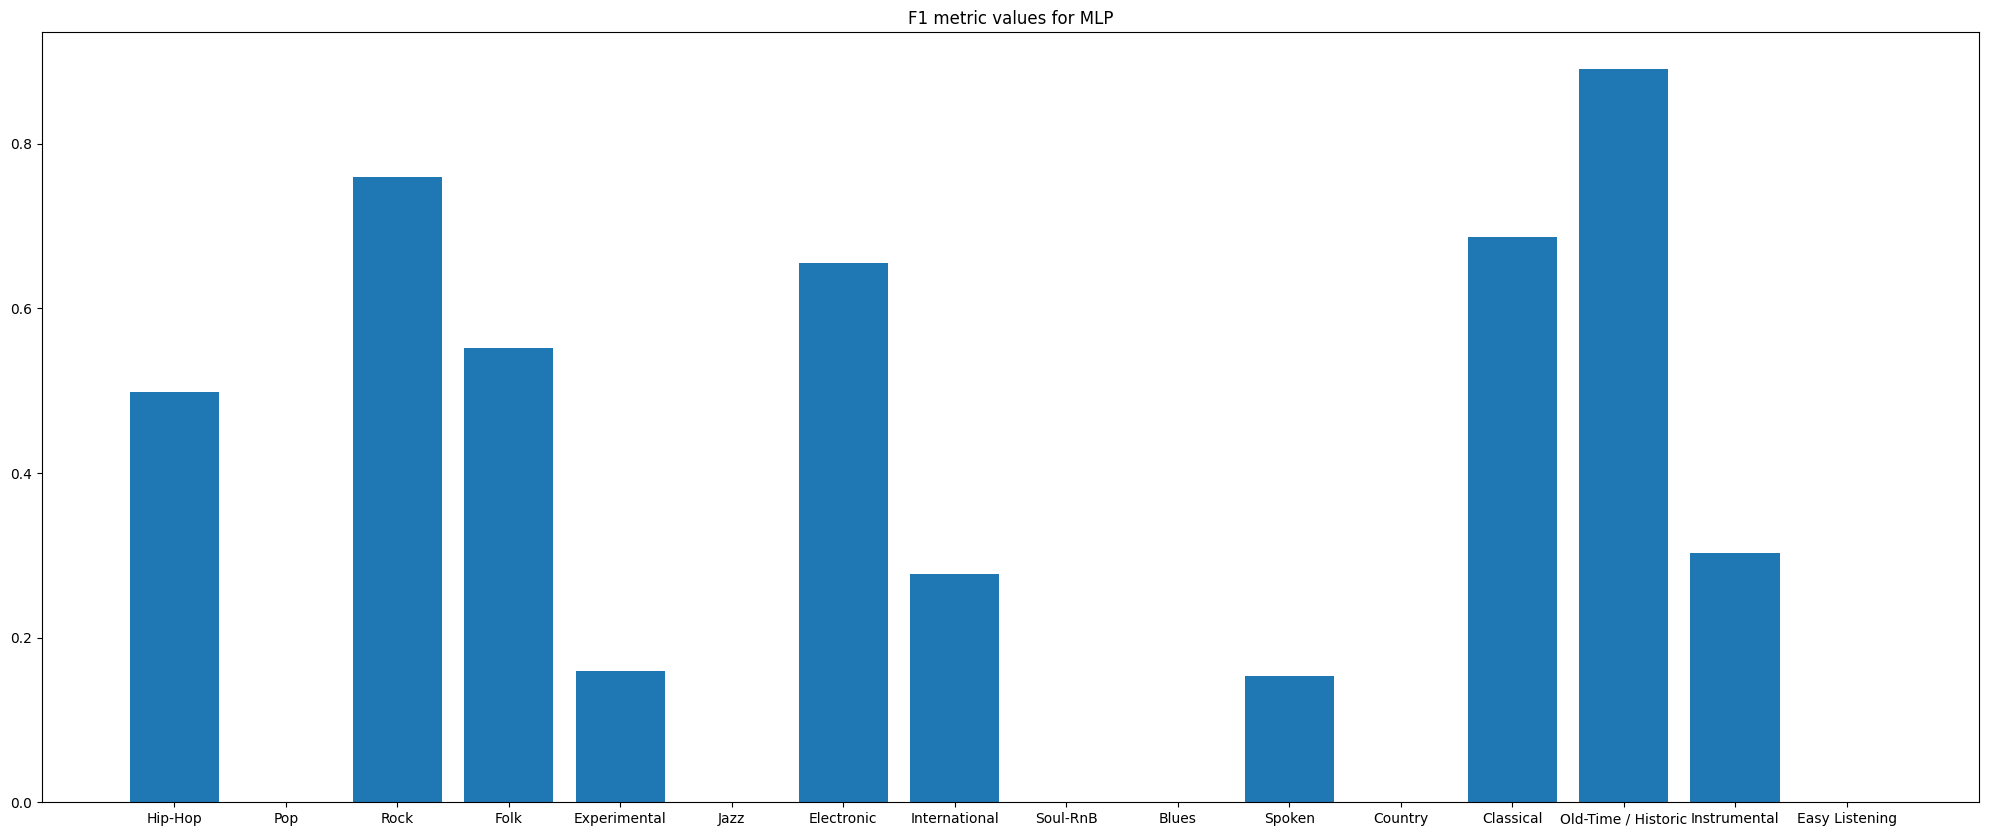

---------------------------------------------------------------------------------------

Decision Tree results: 


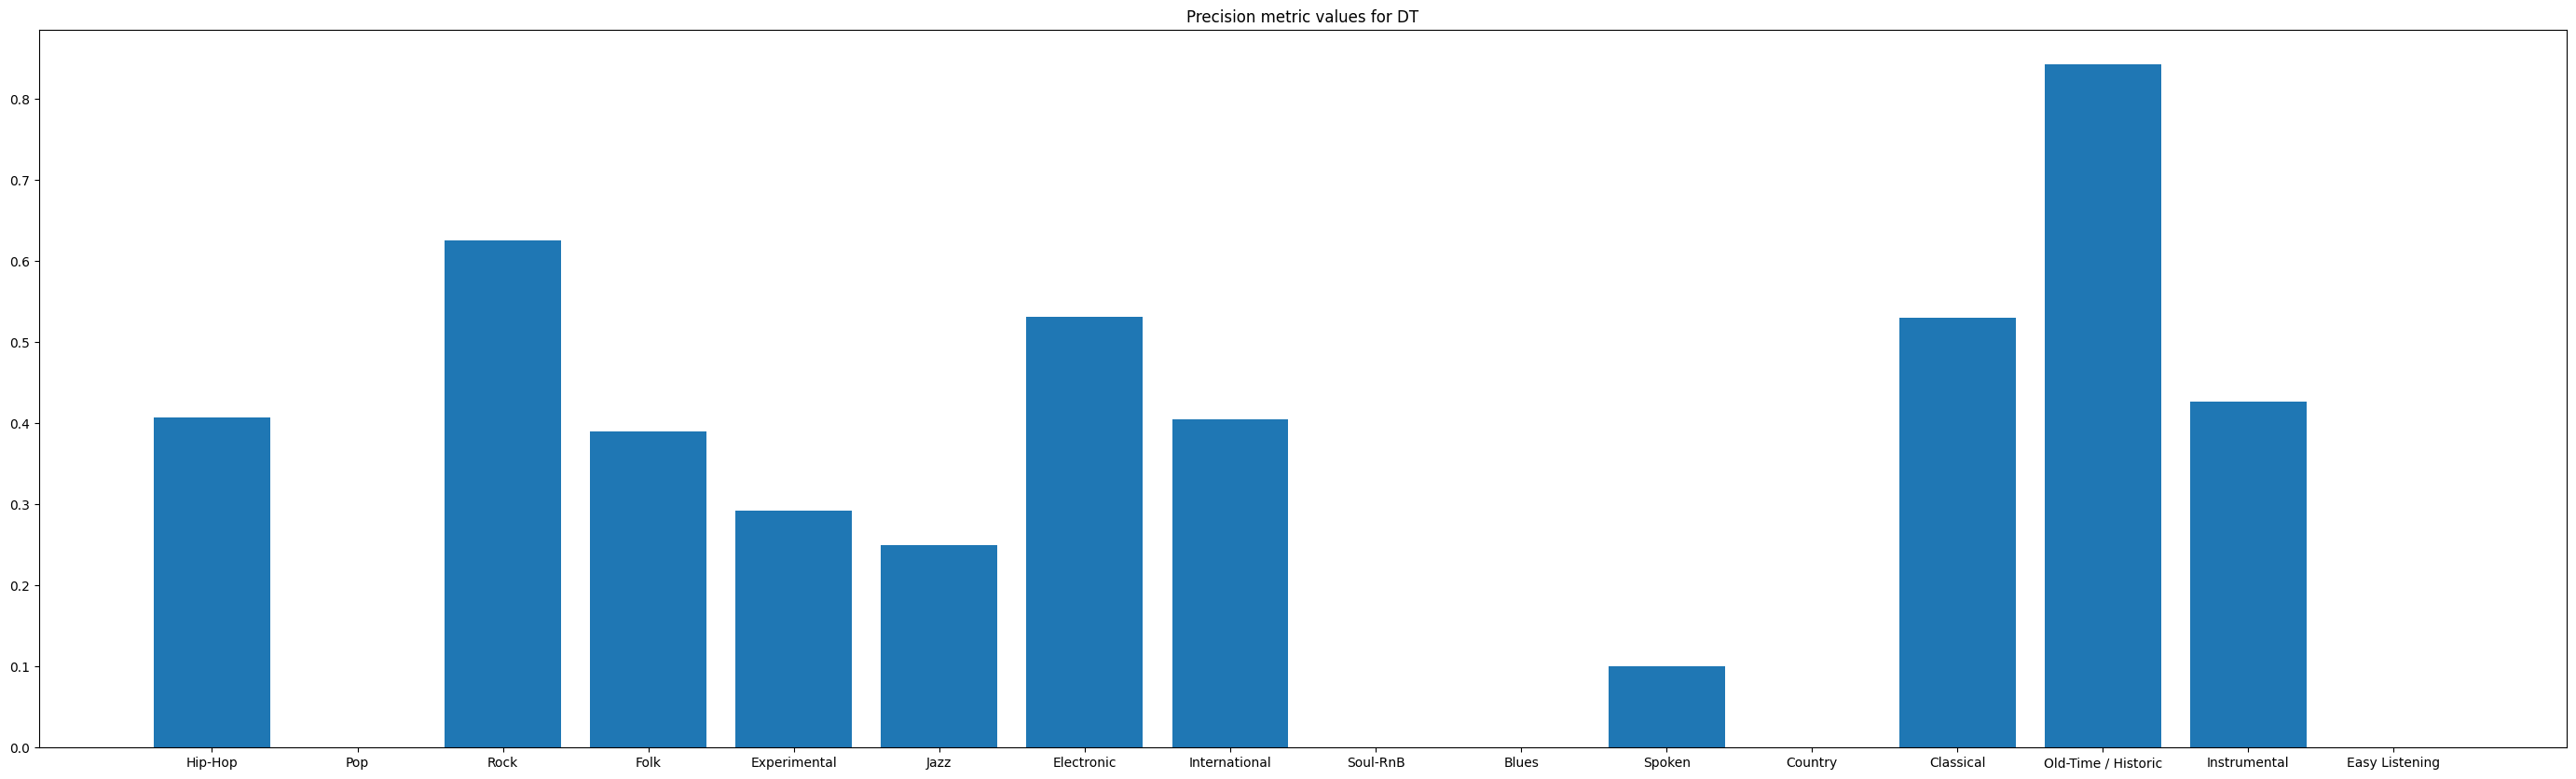

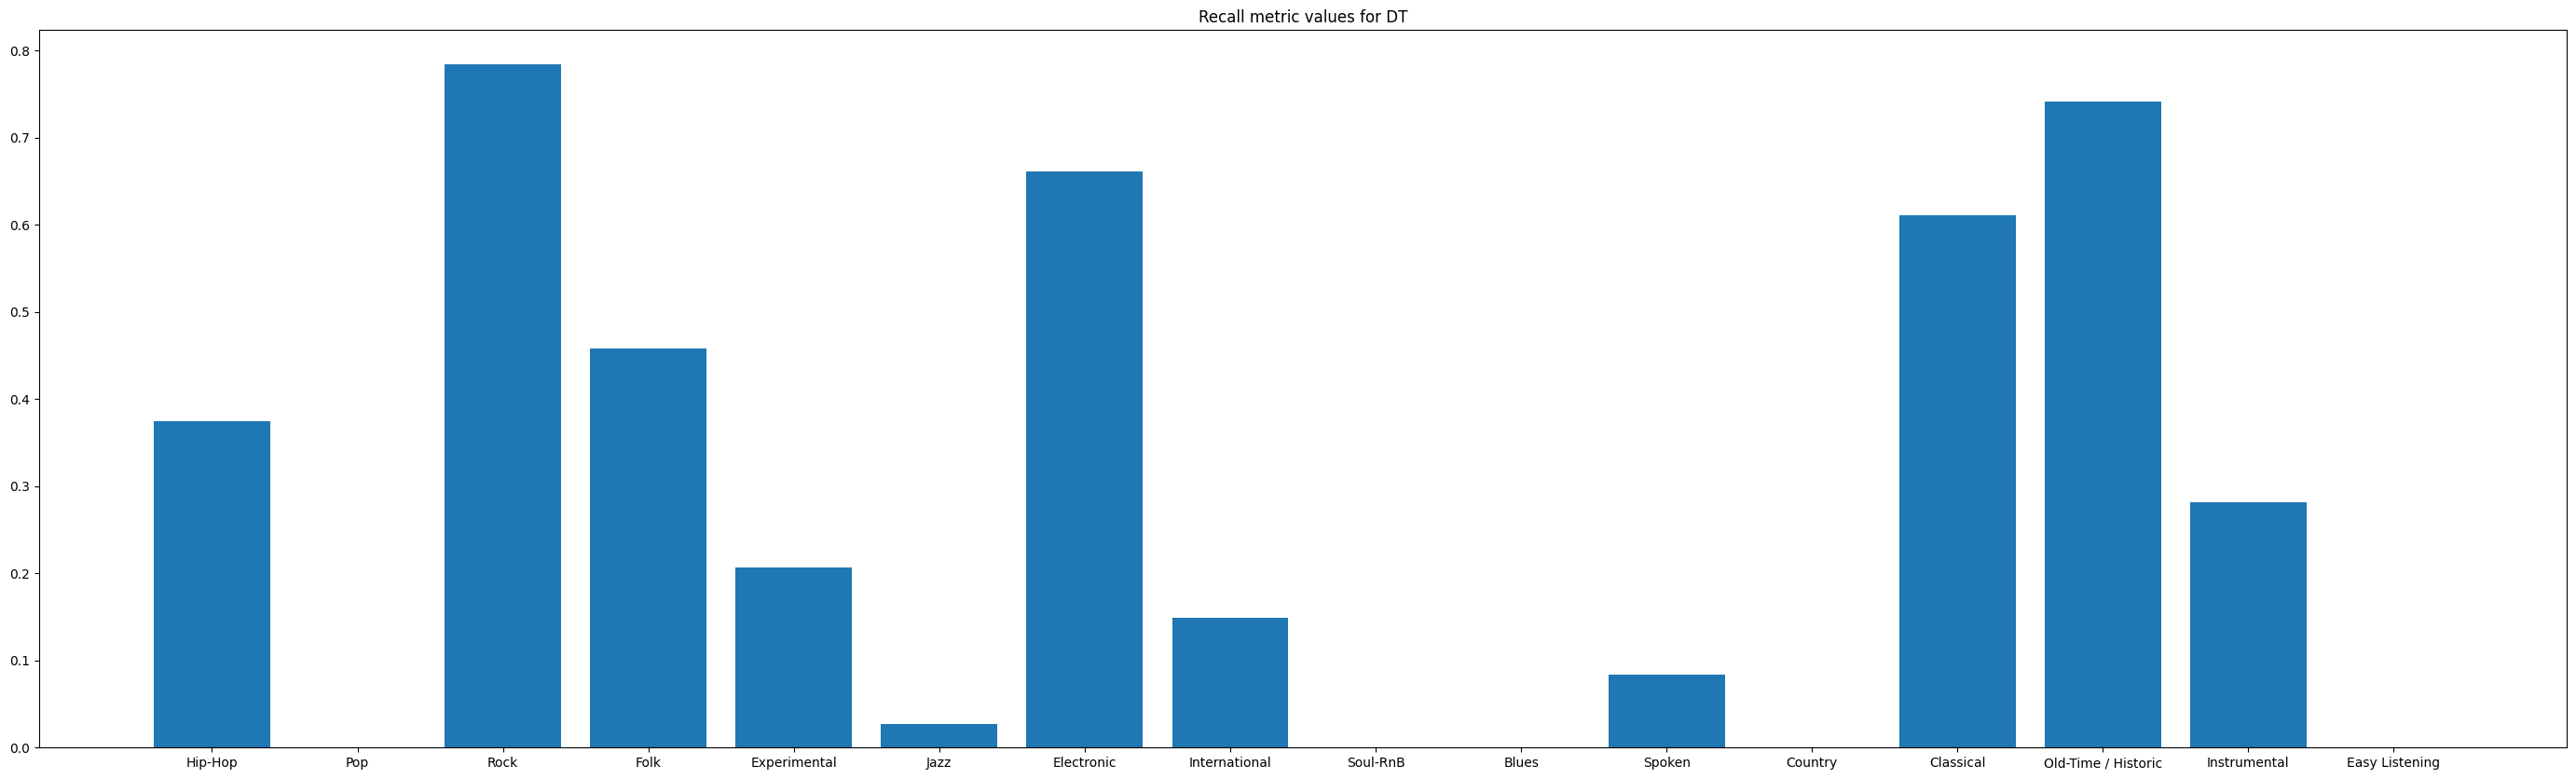

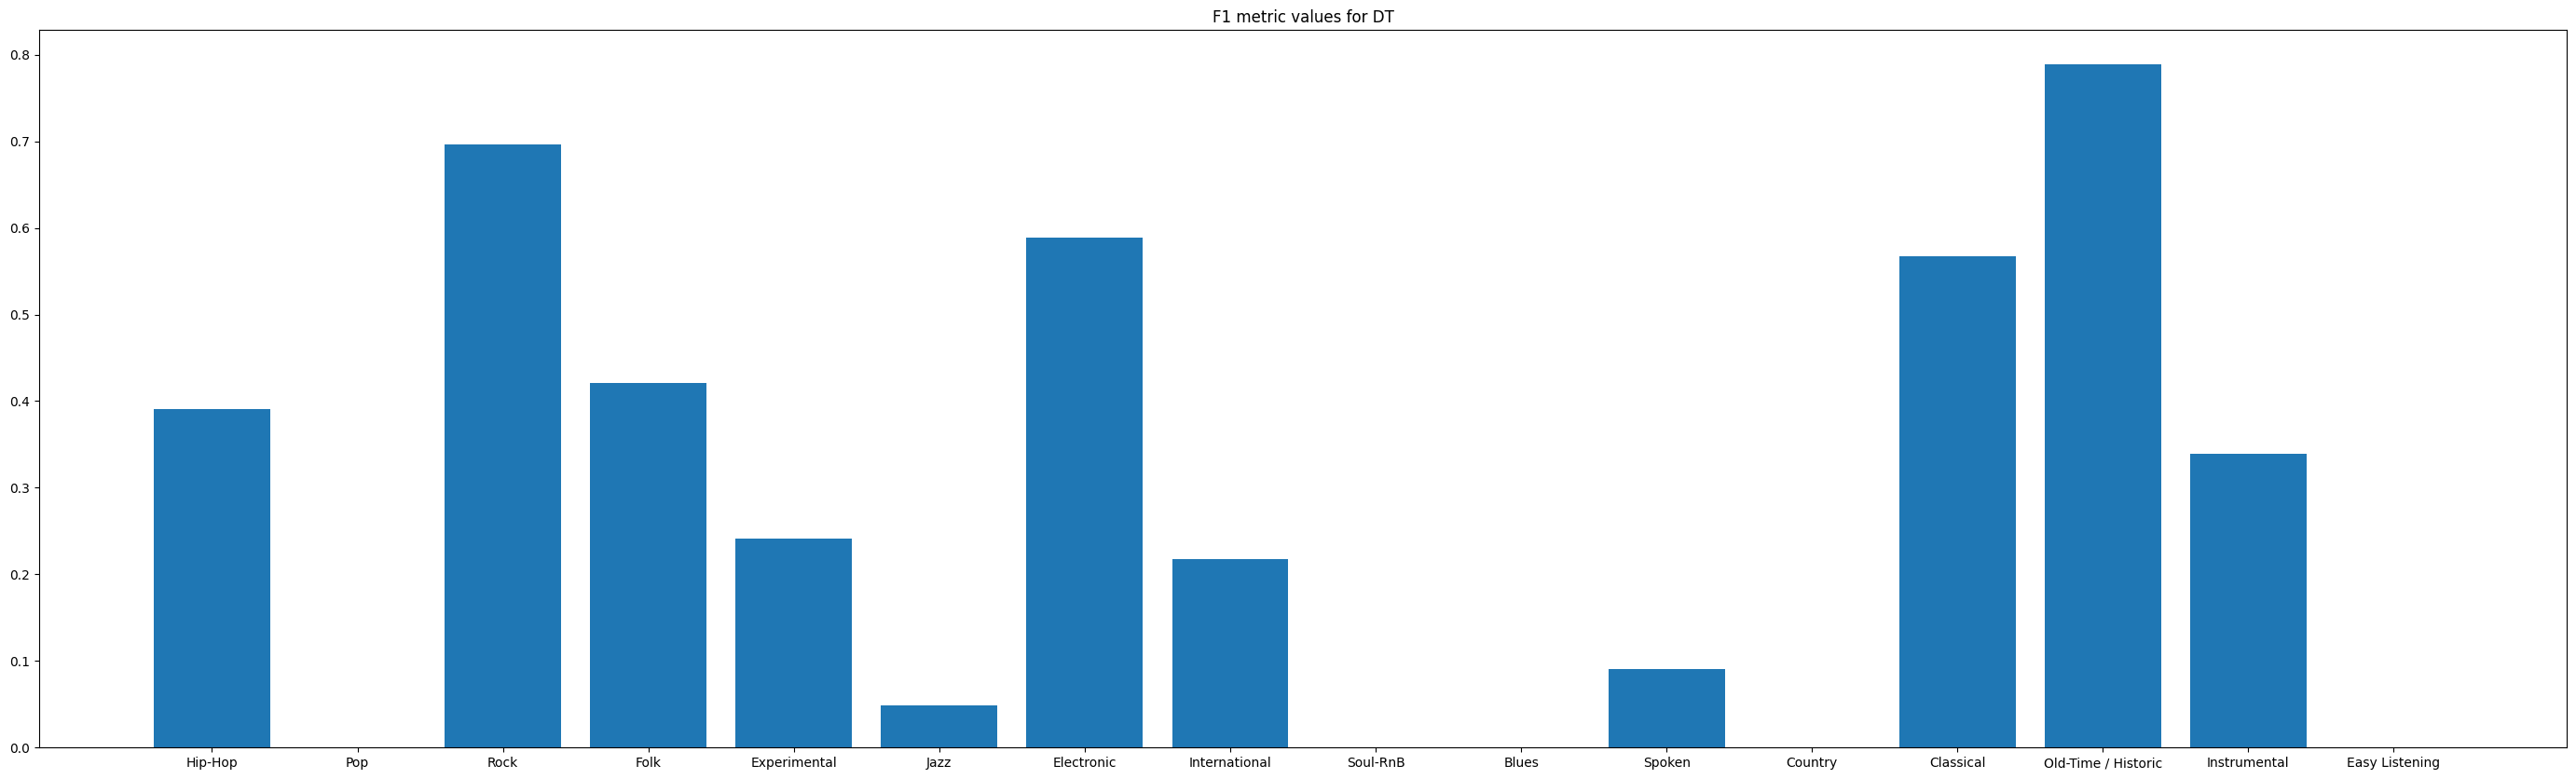

---------------------------------------------------------------------------------------



In [78]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("---------------------------------------------------------------------------------------\n")
print("SVM results:")

bar_plot((25,10), svm_precision_fma, labels, 'Precision metric values for SVM')
bar_plot((25,10), svm_recall_fma, labels, 'Recall metric values for SVM')
bar_plot((25,10), svm_f1_fma, labels, 'F1 metric values for SVM')

'''
# Confusion matrix for SVM
#svm_cm = confusion_matrix(y_test, svm_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''


print("---------------------------------------------------------------------------------------\n")

print("kNN results: ")
bar_plot((25,10), knn_precision_fma, labels, 'Precision metric values for kNN')
bar_plot((25,10), knn_recall_fma, labels, 'Recall metric values for kNN')
bar_plot((25,10), knn_f1_fma, labels, 'F1 metric values for kNN')

'''
# Confusion matrix for kNN
#knn_cm = confusion_matrix(y_test, knn_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")

print("Linear Regression results: ")
bar_plot((25,10), lr_precision_fma, labels, 'Precision metric values for LR')
bar_plot((25,10), lr_recall_fma, labels, 'Recall metric values for LR')
bar_plot((25,10), lr_f1_fma, labels, 'F1 metric values for LR')
'''
# Confusion matrix for LR
#lr_cm = confusion_matrix(y_test, lr_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
bar_plot((25,10), mlp_precision_fma, labels, 'Precision metric values for MLP')
bar_plot((25,10), mlp_recall_fma, labels, 'Recall metric values for MLP')
bar_plot((25,10), mlp_f1_fma, labels, 'F1 metric values for MLP')
'''
# Confusion matrix for SVM
#mlp_cm = confusion_matrix(y_test, mlp_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = mlp_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show()
'''

print("---------------------------------------------------------------------------------------\n")
print("Decision Tree results: ")
bar_plot((25,10), dt_precision_fma, labels, 'Precision metric values for DT')
bar_plot((25,10), dt_recall_fma, labels, 'Recall metric values for DT')
bar_plot((25,10), dt_f1_fma, labels, 'F1 metric values for DT')

print("---------------------------------------------------------------------------------------\n")

## "Challenge"

In [29]:
from utils import open_file_dialog

# Instantiate all the classifiers and fit them
C_best = 20
n_hidden_opt = 70
svm_clf_chall = skl.svm.SVC(C=C_best, kernel='rbf', probability=True).fit(X_train, y_train)
lr_clf_chall = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga').fit(X_train, 
                                                                                    y_train)
knn_clf_chall = KNeighborsClassifier(10).fit(X_train, y_train)
mlp_clf_chall = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n_hidden_opt,), 
                            random_state=1).fit(X_train, y_train)
dt_clf_chall = DecisionTreeClassifier(min_samples_leaf=70).fit(X_train, y_train).fit(X_train, 
                                                                                     y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [33]:
# Open dialogue box
file_path = open_file_dialog()

def get_mfcc(y, sr):
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
    return mfcc

def get_melspectrogram(y, sr):
    melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    return melspectrogram

def get_chroma_stft(y, sr):
    chroma_stft = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    return chroma_stft

def get_tonnetz(y, sr):
    tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
    return tonnetz

def get_chroma_cqt(y, sr):
    chroma_cqt = np.array(librosa.feature.chroma_cqt(y=y, sr=sr))
    return chroma_cqt

def get_chroma_cens(y, sr):
    chroma_cens = np.array(librosa.feature.chroma_cens(y=y, sr=sr))
    return chroma_cens

def get_spectral_centroid(y, sr):
    spectral_centroid = np.array(librosa.feature.spectral_centroid(y=y, sr=sr))
    return spectral_centroid

def get_spectral_bandwidth(y, sr):
    spectral_bandwidth = np.array(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    return spectral_bandwidth

def get_spectral_contrast(y, sr):
    spectral_contrast = np.array(librosa.feature.spectral_contrast(y=y, sr=sr))
    return spectral_contrast

def get_spectral_flatness(y):
    spectral_flatness = np.array(librosa.feature.spectral_flatness(y=y))
    return spectral_flatness

def get_spectral_rolloff(y, sr):
    spectral_rolloff = np.array(librosa.feature.spectral_rolloff(y=y, sr=sr))
    return spectral_rolloff

def get_poly_features(y, sr):
    poly_features = np.array(librosa.feature.poly_features(y=y, sr=sr))
    return poly_features

def get_rms(y):
    rms = np.array(librosa.feature.rms(y=y))
    return rms

def get_zero_crossing_rate(y):
    zero_crossing_rate = np.array(librosa.feature.zero_crossing_rate(y=y))
    return zero_crossing_rate

def get_tempogram(y, sr):
    tempogram = np.array(librosa.feature.tempogram(y=y, sr=sr))
    return tempogram

def calculate_metrics(array):
    features = []
    mean = np.mean(array)
    value_min = np.min(array)
    value_max = np.max(array)
    median = np.median(array)
    std = np.std(array)
    skew = scipy.stats.skew(array, axis=None)
    kurtosis = scipy.stats.kurtosis(array, axis=None)
    features.append(mean)
    features.append(value_min)
    features.append(value_max)
    features.append(median)
    features.append(std)
    features.append(skew)
    features.append(kurtosis)
    return features

    
X_test_elem = [[]]
y, sr = librosa.load(file_path, offset=0, duration=30)
Audio(data=y, rate=sr)
X_test_elem[0].extend(calculate_metrics(get_chroma_stft(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_chroma_cens(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_chroma_cqt(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_melspectrogram(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_mfcc(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_poly_features(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_rms(y)))
X_test_elem[0].extend(calculate_metrics(get_spectral_bandwidth(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_spectral_centroid(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_spectral_contrast(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_spectral_flatness(y)))
X_test_elem[0].extend(calculate_metrics(get_spectral_rolloff(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_tempogram(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_tonnetz(y, sr)))
X_test_elem[0].extend(calculate_metrics(get_zero_crossing_rate(y)))

C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [32]:
# Convert predicitions to a dictionary of the form `label_name`:value
#
# @param string_labels: list of labels
# @param probs:         list of predicted probabilites
#
# @returns: dictonary
def preds_to_dict(string_labels, probs):
    probs_dict = {}
    for index in range(0, len(string_labels)):
        probs_dict[string_labels[index]] = probs[index]
    return probs_dict

# Get the probability scores for each classifier.
# We are supposing that the X train and y train are just the one element that we are trying
# to classify.
string_labels = le.inverse_transform(labels) # convert labels back

svm_probs = svm_clf_chall.predict_proba(X_test_elem)
lr_probs = lr_clf_chall.predict_proba(X_test_elem)
knn_probs = knn_clf_chall.predict_proba(X_test_elem)
mlp_probs = mlp_clf_chall.predict_proba(X_test_elem)
dt_probs = dt_clf_chall.predict_proba(X_test_elem)

print(svm_probs)
print(lr_probs)
print(knn_probs)
print(mlp_probs)
print(dt_probs)

[[0.01229859 0.01142747 0.01901765 0.01024231 0.00189353 0.00188417
  0.52125254 0.04862351 0.03690693 0.00420581 0.10463007 0.12728307
  0.00357272 0.02913621 0.00542641 0.00346059 0.01797726 0.03494471
  0.00581644]]
[[0.01725007 0.01672401 0.03398342 0.01646403 0.0007274  0.00530323
  0.49744339 0.05912257 0.04890982 0.00367556 0.06528011 0.09697673
  0.00356851 0.04540759 0.0024691  0.00767147 0.03145335 0.03414639
  0.01342325]]
[[0.  0.  0.1 0.1 0.  0.  0.5 0.1 0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.
  0. ]]
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  2.32269524e-131 0.00000000e+000 9.99324805e-001 5.29180152e-103
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.32313559e-302 0.00000000e+000 0.00000000e+000 6.75194967e-004
  0.00000000e+000 5.90695573e-129 0.00000000e+000]]
[[0.01298701 0.02597403 0.06493506 0.         0.         0.
  0.32467532 0.11688312 0.03896104 0.01298701 0.09090909 0.
  0.01298701 0.11688312 0.06493506 0.        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


## Conclusions
Conclusioni tipo:
- "miglior" classificatore
- limiti e difficoltà incontrare
- etc...

## Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)